# Part I: From VGG to ResNet [30 pts]
Implement and compare VGG-16 (Version C) and ResNet-18 for image classification. Explore advanced techniques to improve model performance and the transition from standard deep CNNs to networks with residual connections.
The expected accuracy is above 75% for the base model and 80% for the improved model.

In [1]:
                                 #---- Import necessary libraries ----#
import os
import torch
from torchvision import datasets, transforms
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset, random_split
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import random
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from itertools import product
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
%matplotlib inline

In [44]:
                                    ##-----------------------------##
                                    # Sets seed for reproducibility #
                                    ##-----------------------------##

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Step 1: Data preparation

1. Load CNN dataset.

In [8]:
#!unzip cnn_dataset.zip -d /content/cnn_dataset/
dataset_path = "cnn_dataset"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

Analyze the dataset.

In [9]:
class_names = dataset.classes
class_counts = Counter([dataset.targets[i] for i in range(len(dataset))])
df = pd.DataFrame({'Class': class_names, 'Image Count': [class_counts[i] for i in range(len(class_names))]})
print(f"Total Images: {len(dataset)}")
print(f"Number of Classes: {len(class_names)}")
print("\nClass Distribution:\n", df)

Total Images: 30000
Number of Classes: 3

Class Distribution:
       Class  Image Count
0      dogs        10000
1      food        10000
2  vehicles        10000


The above dataset contains 30000 images. there are 3 classes of images namely: dogs, food and vehicles. Each class consists of 10000 images. This is a well balanced dataset with equal images in all the 3 classes. Therefore, we not need perform oversampling or undersampling on the data. It represents 3 different types of things in this: dogs, food and vehicles. The key features would be the equal number of samples in each of the 3 classes.

2.	Create at least three different visualizations to explore the dataset. Provide a short description explaining what each visualization shows.

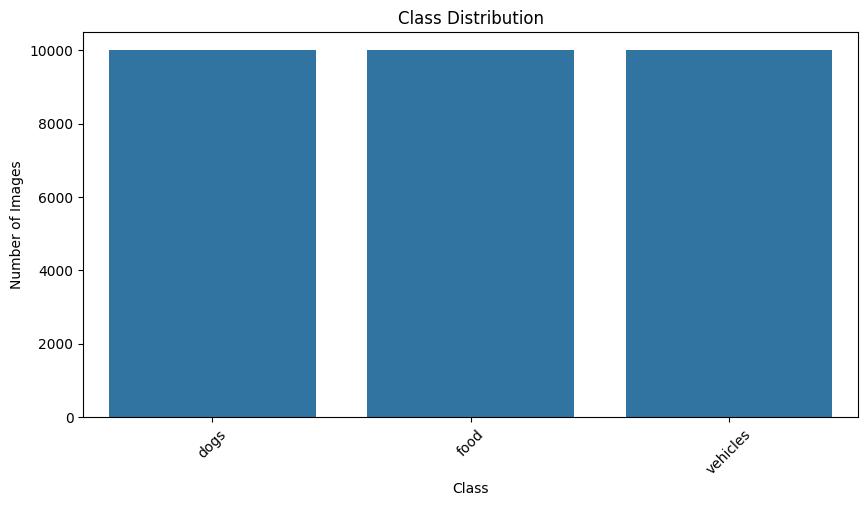

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Image Count', data=df)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

It gives us a quick look at how the dataset is distributed across three categories: dogs, food, and vehicles. Each class has about 10,000 images, meaning the dataset is well-balanced. That’s great news because it ensures no single category dominates the model’s learning process, helping it make fair and accurate predictions across all three groups.

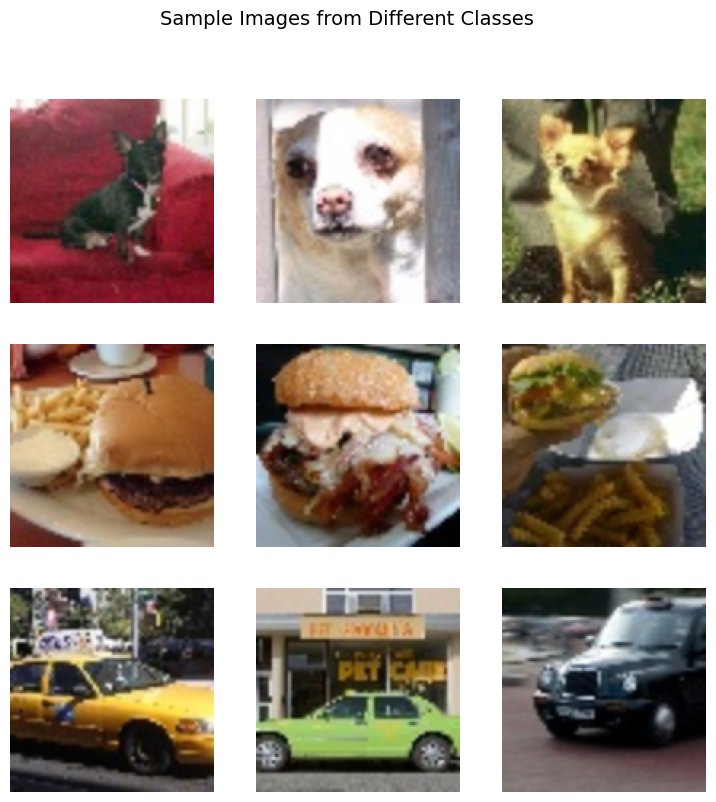

In [ ]:
def show_images_grid(dataset, num_classes=3, samples_per_class=3):
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    class_indices = {i: [] for i in range(len(class_names))}

    for idx, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < samples_per_class:
            class_indices[label].append(idx)

    for row, (class_id, indices) in enumerate(class_indices.items()):
        if row >= num_classes:
            break

        for col, idx in enumerate(indices):
            img, _ = dataset[idx]
            img = img.permute(1, 2, 0).numpy()
            axes[row, col].imshow(img)
            axes[row, col].axis("off")
            if col == 0:
                axes[row, col].set_ylabel(class_names[class_id], fontsize=12)

    plt.suptitle("Sample Images from Different Classes", fontsize=14)
    plt.show()

show_images_grid(dataset)

This image grid gives us a quick sneak peek at the dataset, showing examples from three different categories: dogs, food, and vehicles. The top row has dogs, the middle row is all about burgers and fries, and the bottom row features different types of cars. This kind of visualization is super useful because it helps us make sure the images are clear, diverse, and properly labeled before we dive into training a model.

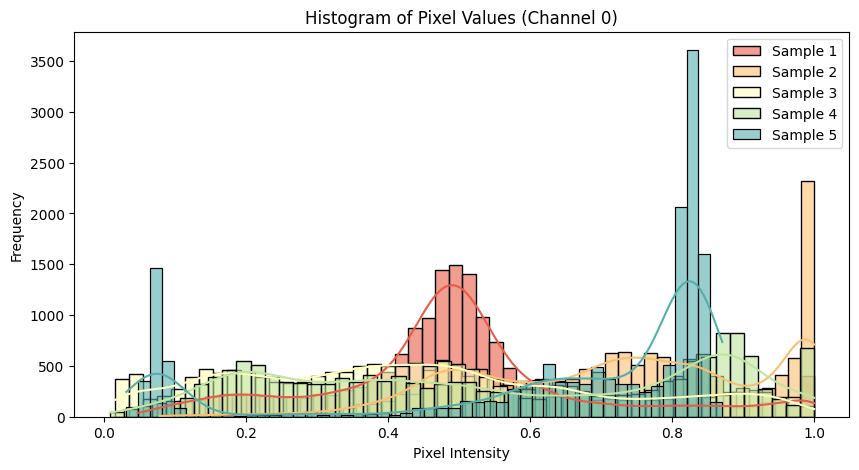

In [ ]:
def plot_pixel_histogram(dataset, num_samples=5, channel=0):
    plt.figure(figsize=(10, 5))
    colors = sns.color_palette("Spectral",num_samples)

    for i in range(num_samples):
        img, _ = dataset[i]
        img_np = img[channel].numpy().flatten()
        sns.histplot(img_np, bins=50, kde=True, alpha=0.6,
                     label=f"Sample {i+1}", color=colors[i])

    plt.title(f"Histogram of Pixel Values (Channel {channel})")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_pixel_histogram(dataset)


It shows how pixel intensity values are distributed in the first color channel for five different image samples. Each sample has its own color, with bars representing how often certain intensity values appear. The smooth lines help show the overall trend of the data. You can see that some intensity levels are much more common than others, creating noticeable peaks. This gives a sense of the brightness patterns in the images and how they differ from one sample to another.

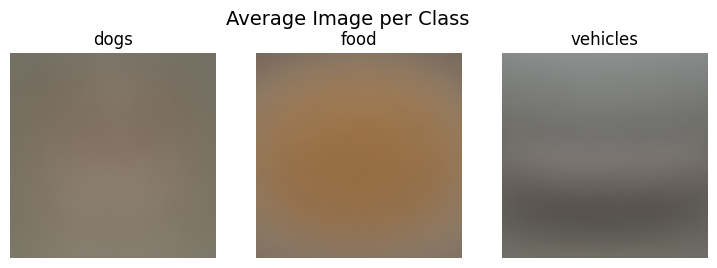

In [ ]:
def compute_average_images(dataset):
    class_sums = {i: torch.zeros_like(dataset[0][0]) for i in range(len(class_names))}
    class_counts = Counter(dataset.targets)

    for img, label in dataset:
        class_sums[label] += img

    class_averages = {label: (class_sums[label] / class_counts[label]) for label in class_sums}

    fig, axes = plt.subplots(1, len(class_averages), figsize=(len(class_averages) * 3, 3))
    for i, (label, avg_img) in enumerate(class_averages.items()):
        avg_img = avg_img.permute(1, 2, 0).numpy()
        axes[i].imshow(avg_img)
        axes[i].set_title(class_names[label])
        axes[i].axis("off")

    plt.suptitle("Average Image per Class", fontsize=14)
    plt.show()

compute_average_images(dataset)

This image gives a blurry, averaged-out look at what each category—dogs, food, and vehicles—tends to look like. By blending multiple images together, we lose the details but keep the overall colors and textures. You can see that food has a warmer, brownish tone, while vehicles lean toward grays.

3. Preprocess the dataset.

In [11]:
add_norm_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


dataset.transform = transforms.Compose([
    dataset.transform,
    add_norm_transform
])
targets = torch.LongTensor(dataset.targets)

4. Split the dataset into training, testing, and validation sets.

In [12]:
indices = np.arange(len(dataset))
train_idx, test_val_idx = train_test_split(indices, test_size=0.3, stratify=dataset.targets, random_state=42)
val_idx, test_idx = train_test_split(test_val_idx, test_size=0.5, stratify=[dataset.targets[i] for i in test_val_idx], random_state=42)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Training set: 21000 images
Validation set: 4500 images
Test set: 4500 images


## Step 2: Implementing VGG

1. Implement the VGG-16 (Version C) architecture.

In [13]:
class VGG_16_model(nn.Module):

    def __init__(self, num_classes=3):
        super(VGG_16_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [14]:
def xavier(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def kaiming(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [15]:
def run_an_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    runningLoss = 0.0
    runningCorrects = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        runningLoss += loss.item() * inputs.size(0)
        runningCorrects += torch.sum(preds == labels.data)

    epoch_loss = runningLoss / len(data_loader.dataset)
    epoch_acc = runningCorrects.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc


In [16]:
def evaluate_an_epoch(model, data_loader, criterion, device):
    model.eval()
    runningLoss = 0.0
    runningCorrects = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            runningLoss += loss.item() * inputs.size(0)
            runningCorrects += torch.sum(preds == labels.data)

    epoch_loss = runningLoss / len(data_loader.dataset)
    epoch_acc = runningCorrects.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc


In [17]:
def train_function(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        train_loss, train_acc = run_an_epoch(model, train_loader, criterion, optimizer, device)
        scheduler.step()
        val_loss, val_acc = evaluate_an_epoch(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n")
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}\n")
    model.load_state_dict(best_model_wts)
    return model


In [18]:
def test_function(model, test_loader, device):
    model.eval()
    runningCorrects = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            X, preds = torch.max(outputs, 1)
            runningCorrects += torch.sum(preds == labels.data)

    test_acc = runningCorrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

In [19]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
number_classes = len(class_names)
optimizer_list = ['SGD', 'Adam', 'AdamW']
batch_size = [32, 64]
xavier_results = []
print("Xavier weight initialization:")

for opt_name in optimizer_list:

    for b_size in batch_size:
        print(f"Present configuration: Weights initialization = Xavier, Optimizer = {opt_name}, Batch Size = {b_size}")
        train_loader, val_loader, test_loader = create_dataloaders(b_size)
        model = VGG_16_model(num_classes=number_classes).to(device)
        model.apply(xavier)
        criterion = nn.CrossEntropyLoss()
        if opt_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
        elif opt_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        elif opt_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)
        start_time = time.time()
        trained_model = train_function(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10)
        total_time = time.time() - start_time
        avg_epoch_time = total_time / 10
        print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")
        test_acc = test_function(trained_model, test_loader, device)
        print("\n")
        xavier_results.append({
            'weight_init': 'Xavier',
            'optimizer': opt_name,
            'batch_size': b_size,
            'avg_epoch_time': avg_epoch_time,
            'test_accuracy': test_acc.item()
        })

print("Summary of Xavier results:")
for res in xavier_results:
    print(res)

Using device: cuda
Running experiments with Xavier weight initialization
Configuration: Weight Init = Xavier, Optimizer = SGD, Batch Size = 32
Epoch 1/10
----------
Train Loss: 0.7993 Acc: 0.6148
Val   Loss: 0.5169 Acc: 0.7956

Epoch 2/10
----------
Train Loss: 0.5078 Acc: 0.7950
Val   Loss: 0.4268 Acc: 0.8320

Epoch 3/10
----------
Train Loss: 0.4137 Acc: 0.8419
Val   Loss: 0.3567 Acc: 0.8653

Epoch 4/10
----------
Train Loss: 0.3777 Acc: 0.8544
Val   Loss: 0.3325 Acc: 0.8667

Epoch 5/10
----------
Train Loss: 0.3281 Acc: 0.8740
Val   Loss: 0.3641 Acc: 0.8522

Epoch 6/10
----------
Train Loss: 0.2879 Acc: 0.8900
Val   Loss: 0.3144 Acc: 0.8869

Epoch 7/10
----------
Train Loss: 0.2552 Acc: 0.9050
Val   Loss: 0.3008 Acc: 0.8838

Epoch 8/10
----------
Train Loss: 0.2406 Acc: 0.9073
Val   Loss: 0.3906 Acc: 0.8556

Epoch 9/10
----------
Train Loss: 0.2130 Acc: 0.9193
Val   Loss: 0.2759 Acc: 0.8958

Epoch 10/10
----------
Train Loss: 0.1914 Acc: 0.9280
Val   Loss: 0.2649 Acc: 0.9007

Traini

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names)
optimizer_list = ['SGD', 'Adam', 'AdamW']
batch_size = [32, 64]
kaiming_results = []
print("Kaiming weight initialization")

for opt_name in optimizer_list:

    for b_size in batch_size:
        print(f"Present configuration: Weight initialization = Kaiming, Optimizer = {opt_name}, Batch Size = {b_size}")
        train_loader, val_loader, test_loader = create_dataloaders(b_size)
        model = VGG_16_model(num_classes=num_classes).to(device)
        model.apply(kaiming)
        criterion = nn.CrossEntropyLoss()
        if opt_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
        elif opt_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        elif opt_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)
        start_time = time.time()
        trained_model = train_function(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10)
        total_time = time.time() - start_time
        avg_epoch_time = total_time / 10
        print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")
        test_acc = test_function(trained_model, test_loader, device)
        print("\n")
        kaiming_results.append({
            'weight_init': 'Kaiming',
            'optimizer': opt_name,
            'batch_size': b_size,
            'avg_epoch_time': avg_epoch_time,
            'test_accuracy': test_acc.item()
        })

print("Summary of Kaiming results:")
for res in kaiming_results:
    print(res)

Using device: cuda
Running experiments with Kaiming weight initialization
Configuration: Weight Init = Kaiming, Optimizer = SGD, Batch Size = 32
Epoch 1/10
----------
Train Loss: 0.8385 Acc: 0.6055
Val   Loss: 0.5360 Acc: 0.7907

Epoch 2/10
----------
Train Loss: 0.4977 Acc: 0.8062
Val   Loss: 0.4669 Acc: 0.8118

Epoch 3/10
----------
Train Loss: 0.4241 Acc: 0.8362
Val   Loss: 0.4711 Acc: 0.8111

Epoch 4/10
----------
Train Loss: 0.3765 Acc: 0.8546
Val   Loss: 0.4011 Acc: 0.8471

Epoch 5/10
----------
Train Loss: 0.3506 Acc: 0.8657
Val   Loss: 0.3430 Acc: 0.8602

Epoch 6/10
----------
Train Loss: 0.3194 Acc: 0.8812
Val   Loss: 0.2964 Acc: 0.8858

Epoch 7/10
----------
Train Loss: 0.2901 Acc: 0.8914
Val   Loss: 0.3080 Acc: 0.8816

Epoch 8/10
----------
Train Loss: 0.2713 Acc: 0.9003
Val   Loss: 0.3291 Acc: 0.8660

Epoch 9/10
----------
Train Loss: 0.2566 Acc: 0.9045
Val   Loss: 0.2903 Acc: 0.8809

Epoch 10/10
----------
Train Loss: 0.2435 Acc: 0.9104
Val   Loss: 0.2315 Acc: 0.9144

Trai

Training results and summary:<br>
1. SGD Performs Best:<br>
The SGD optimizer consistently achieved the highest accuracy, making it the most reliable choice for this setup.
Using Xavier initialization with SGD, the model achieved an accuracy of 91.11%, while Kaiming initialization with SGD performed slightly better at 92.31%.
Training time varied slightly depending on batch size, but SGD consistently provided strong results.
2. Adam and AdamW Failed to Learn:<br>
Regardless of the weight initialization method used, Adam and AdamW resulted in an accuracy of 33.3%, which is equivalent to random guessing.
A conflict between batch normalization and Adam-based optimizers could be the issue.
3. Kaiming vs. Xavier Initialization:<br>
Kaiming initialization provided slightly better accuracy than Xavier when used with SGD.
However, this improvement came at the cost of longer training times—Kaiming took about 10-15 seconds longer per epoch compared to Xavier.
4. Effect of Batch Size:<br>
Larger batch sizes (64) consistently reduced training time across all configurations.
However, with Xavier + SGD, increasing batch size to 64 caused a slight accuracy drop (from 91.1% to 89.9%).
Interestingly, with Kaiming + SGD, the larger batch size (64) improved accuracy (from 92.3% to 92.7%), making it the optimal choice in this case.

### Base Model(Model with highest accuracy obtained in hyperparameter tuning)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names)
b_size = 64
train_loader, val_loader, test_loader = create_dataloaders(b_size)
model = VGG_16_model(num_classes=num_classes).to(device)
model.apply(kaiming)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)
start_time = time.time()
trained_model = train_function(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10)
total_time = time.time() - start_time
avg_epoch_time = total_time / 30
print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")
test_acc = test_function(trained_model, test_loader, device)
print("\n")
print("Test Accuracy:", test_acc)

Using device: cuda
Epoch 1/10
----------
Train Loss: 0.7941 Acc: 0.6596
Val   Loss: 0.5190 Acc: 0.7978

Epoch 2/10
----------
Train Loss: 0.4881 Acc: 0.8069
Val   Loss: 0.4113 Acc: 0.8418

Epoch 3/10
----------
Train Loss: 0.4145 Acc: 0.8394
Val   Loss: 0.4776 Acc: 0.8129

Epoch 4/10
----------
Train Loss: 0.3670 Acc: 0.8604
Val   Loss: 0.3906 Acc: 0.8547

Epoch 5/10
----------
Train Loss: 0.3296 Acc: 0.8750
Val   Loss: 0.3781 Acc: 0.8500

Epoch 6/10
----------
Train Loss: 0.3024 Acc: 0.8873
Val   Loss: 0.2942 Acc: 0.8860

Epoch 7/10
----------
Train Loss: 0.2798 Acc: 0.8958
Val   Loss: 0.2607 Acc: 0.9022

Epoch 8/10
----------
Train Loss: 0.2528 Acc: 0.9062
Val   Loss: 0.3762 Acc: 0.8611

Epoch 9/10
----------
Train Loss: 0.2418 Acc: 0.9116
Val   Loss: 0.3491 Acc: 0.8667

Epoch 10/10
----------
Train Loss: 0.2207 Acc: 0.9166
Val   Loss: 0.2387 Acc: 0.9093

Training complete in 16m 10s
Best val Acc: 0.9093

Average time per epoch: 32.33 seconds
Test Accuracy: 0.9169


Test Accuracy: te

4. Apply regularization and overfitting prevention techniques.

In [20]:
def xavier(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [21]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

In [22]:
def mixup_function(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [23]:
def run_an_epoch(model, dataloader, criterion, optimizer, device, use_mixup=False, mixup_alpha=1.0):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        if use_mixup:
            inputs, targets_a, targets_b, lam = mixup_function(inputs, labels, mixup_alpha)
            outputs = model(inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            _, preds = torch.max(outputs, 1)
            correct = lam * (preds == targets_a).float() + (1 - lam) * (preds == targets_b).float()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        if use_mixup:
            running_corrects += torch.sum(correct)
        else:
            running_corrects += torch.sum(preds == labels.data)
        total += inputs.size(0)

    return running_loss / total, running_corrects.double() / total

In [24]:
def evaluate_an_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += inputs.size(0)

    return running_loss / total, running_corrects.double() / total

In [25]:
def test_model_with_all_the_metrics(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    all_labels, all_preds = [], []

    with torch.no_grad():

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return running_loss / total, running_corrects.double() / total, all_labels, all_preds

In [26]:
def plot_training(epochs, train_vals, val_vals, ylabel, title, filename):
    plt.figure()
    plt.plot(epochs, train_vals, label="Train")
    plt.plot(epochs, val_vals, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(filename)
    plt.show()

In [27]:
def plot_confusion(all_labels, all_preds, method_name):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({method_name})")
    plt.savefig(f"{method_name}_confusion_matrix.svg")
    plt.show()
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"{method_name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

In [28]:
def show_misclassified_images(model, dataloader, device, method_name):
    misclassified_images, misclassified_true, misclassified_pred = [], [], []
    model.eval()

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(inputs.size(0)):
            if preds[i] != labels[i]:
                misclassified_images.append(inputs[i].cpu())
                misclassified_true.append(labels[i].cpu().item())
                misclassified_pred.append(preds[i].cpu().item())

        if len(misclassified_images) >= 5:
            break

    plt.figure(figsize=(12,6))

    for i in range(min(5, len(misclassified_images))):
        image = misclassified_images[i].permute(1, 2, 0).numpy()
        plt.subplot(1,5,i+1)
        plt.imshow(image)
        plt.title(f"True: {class_names[misclassified_true[i]]}\nPred: {class_names[misclassified_pred[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{method_name}_misclassified.svg")
    plt.show()


In [29]:
def train_with_image_augmentation(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    writer = SummaryWriter(log_dir="runs/experiment_augmentation")
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        t_loss, t_acc = run_an_epoch(model, train_loader, criterion, optimizer, device, use_mixup=False)
        v_loss, v_acc = evaluate_an_epoch(model, val_loader, criterion, device)
        scheduler.step()
        train_losses.append(t_loss)
        train_accs.append(t_acc.item())
        val_losses.append(v_loss)
        val_accs.append(v_acc.item())
        writer.add_scalar("Augmentation/Train Loss", t_loss, epoch)
        writer.add_scalar("Augmentation/Train Accuracy", t_acc, epoch)
        writer.add_scalar("Augmentation/Validation Loss", v_loss, epoch)
        writer.add_scalar("Augmentation/Validation Accuracy", v_acc, epoch)
        print(f"(Augmentation) Epoch {epoch+1}/{num_epochs} -- Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")

    writer.close()
    return model, train_losses, train_accs, val_losses, val_accs

In [30]:
def train_with_early_stopping_method(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, patience=3):
    writer = SummaryWriter(log_dir="runs/experiment_earlystopping")
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        t_loss, t_acc = run_an_epoch(model, train_loader, criterion, optimizer, device, use_mixup=False)
        v_loss, v_acc = evaluate_an_epoch(model, val_loader, criterion, device)
        scheduler.step()
        train_losses.append(t_loss)
        train_accs.append(t_acc.item())
        val_losses.append(v_loss)
        val_accs.append(v_acc.item())
        writer.add_scalar("EarlyStopping/Train Loss", t_loss, epoch)
        writer.add_scalar("EarlyStopping/Train Accuracy", t_acc, epoch)
        writer.add_scalar("EarlyStopping/Validation Loss", v_loss, epoch)
        writer.add_scalar("EarlyStopping/Validation Accuracy", v_acc, epoch)
        print(f"(EarlyStopping) Epoch {epoch+1}/{num_epochs} -- Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")
        if v_loss < best_val_loss:
            best_val_loss = v_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    writer.close()
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs, val_losses, val_accs

In [31]:
def train_with_mixup_method(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10, mixup_alpha=1.0):
    writer = SummaryWriter(log_dir="runs/experiment_mixup")
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        t_loss, t_acc = run_an_epoch(model, train_loader, criterion, optimizer, device, use_mixup=True, mixup_alpha=mixup_alpha)
        v_loss, v_acc = evaluate_an_epoch(model, val_loader, criterion, device)
        scheduler.step()
        train_losses.append(t_loss)
        train_accs.append(t_acc.item())
        val_losses.append(v_loss)
        val_accs.append(v_acc.item())
        writer.add_scalar("Mixup/Train Loss", t_loss, epoch)
        writer.add_scalar("Mixup/Train Accuracy", t_acc, epoch)
        writer.add_scalar("Mixup/Validation Loss", v_loss, epoch)
        writer.add_scalar("Mixup/Validation Accuracy", v_acc, epoch)
        print(f"(Mixup) Epoch {epoch+1}/{num_epochs} -- Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")

    writer.close()
    return model, train_losses, train_accs, val_losses, val_accs

In [32]:
batch_size = 64
train_loader, val_loader, test_loader = create_dataloaders(batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names)

Using device: cuda



=== Experiment 1: Image Augmentation Only ===
(Augmentation) Epoch 1/10 -- Train Loss: 0.7713, Train Acc: 0.6664, Val Loss: 0.6992, Val Acc: 0.7220
(Augmentation) Epoch 2/10 -- Train Loss: 0.4746, Train Acc: 0.8129, Val Loss: 0.4188, Val Acc: 0.8451
(Augmentation) Epoch 3/10 -- Train Loss: 0.3933, Train Acc: 0.8476, Val Loss: 0.3498, Val Acc: 0.8662
(Augmentation) Epoch 4/10 -- Train Loss: 0.3393, Train Acc: 0.8751, Val Loss: 0.3302, Val Acc: 0.8818
(Augmentation) Epoch 5/10 -- Train Loss: 0.3111, Train Acc: 0.8823, Val Loss: 0.3464, Val Acc: 0.8647
(Augmentation) Epoch 6/10 -- Train Loss: 0.2735, Train Acc: 0.9008, Val Loss: 0.3257, Val Acc: 0.8824
(Augmentation) Epoch 7/10 -- Train Loss: 0.2536, Train Acc: 0.9067, Val Loss: 0.3032, Val Acc: 0.8851
(Augmentation) Epoch 8/10 -- Train Loss: 0.2307, Train Acc: 0.9152, Val Loss: 0.2455, Val Acc: 0.9071
(Augmentation) Epoch 9/10 -- Train Loss: 0.2155, Train Acc: 0.9217, Val Loss: 0.2301, Val Acc: 0.9209
(Augmentation) Epoch 10/10 -- Train

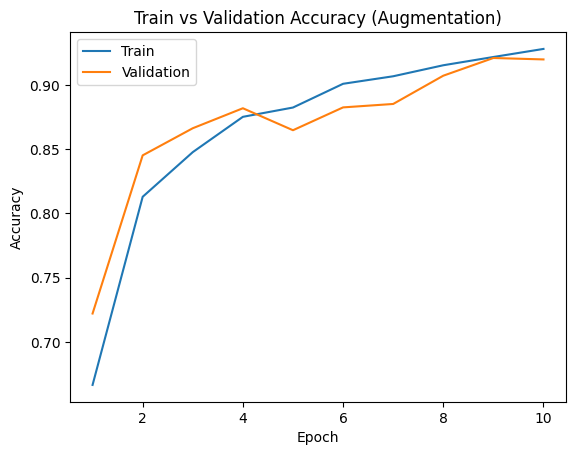

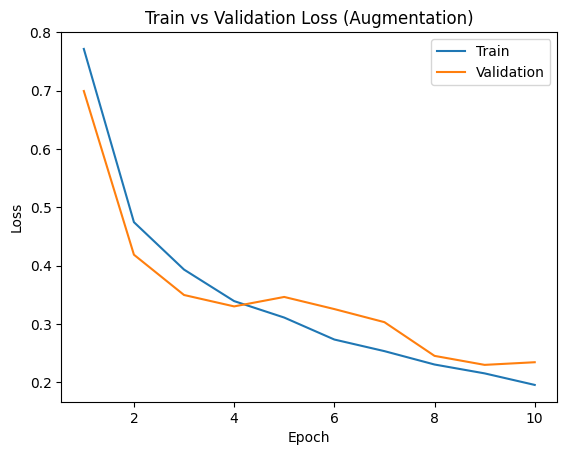

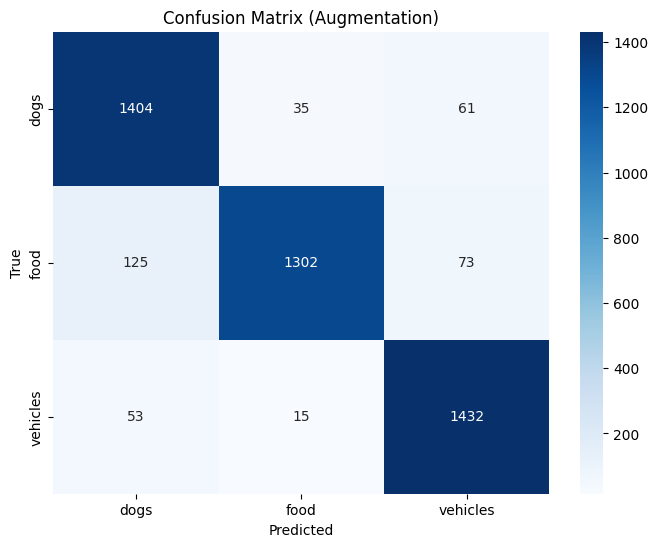

Augmentation - Precision: 0.9216, Recall: 0.9196, F1 Score: 0.9194


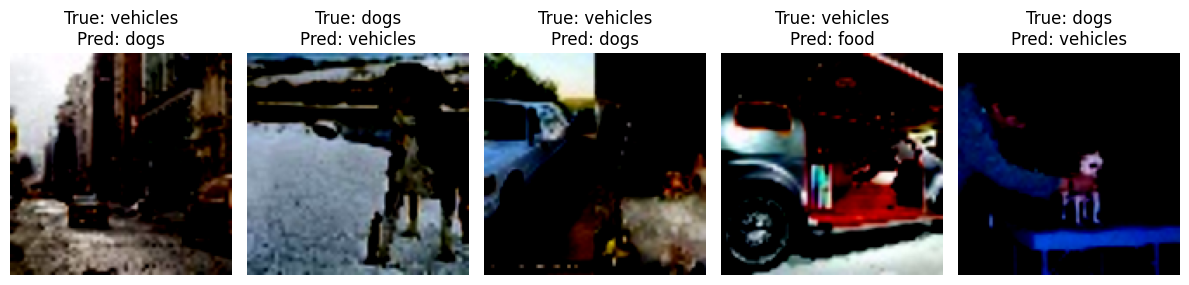

In [ ]:
print("\n=== Experiment 1: Image Augmentation Only ===")
aug_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor()
])
train_dataset.transform = aug_transforms
model_augmentation = VGG_16_model(num_classes=num_classes).to(device)
model_augmentation.apply(kaiming)
optimizer_aug = optim.SGD(model_augmentation.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_aug = lr_scheduler.MultiStepLR(optimizer_aug, milestones=[15, 25], gamma=0.1)
model_augmentation, train_losses_aug, train_accs_aug, val_losses_aug, val_accs_aug = train_with_image_augmentation(
    model_augmentation, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_aug, scheduler_aug, device, num_epochs=10
)
test_loss_aug, test_acc_aug, all_labels_aug, all_preds_aug = test_model_with_all_the_metrics(model_augmentation, test_loader, nn.CrossEntropyLoss(), device)
print(f"(Augmentation) Test Loss: {test_loss_aug:.4f}, Test Acc: {test_acc_aug:.4f}")
epochs_range_aug = range(1, len(train_losses_aug)+1)
plot_training(epochs_range_aug, train_accs_aug, val_accs_aug, "Accuracy", "Train vs Validation Accuracy (Augmentation)", "aug_accuracy_plot.svg")
plot_training(epochs_range_aug, train_losses_aug, val_losses_aug, "Loss", "Train vs Validation Loss (Augmentation)", "aug_loss_plot.svg")
plot_confusion(all_labels_aug, all_preds_aug, "Augmentation")
show_misclassified_images(model_augmentation, test_loader, device, "Augmentation")


=== Experiment 2: Early Stopping Only ===
(EarlyStopping) Epoch 1/10 -- Train Loss: 0.8223, Train Acc: 0.6156, Val Loss: 0.5053, Val Acc: 0.7922
(EarlyStopping) Epoch 2/10 -- Train Loss: 0.4877, Train Acc: 0.8074, Val Loss: 0.4513, Val Acc: 0.8151
(EarlyStopping) Epoch 3/10 -- Train Loss: 0.4195, Train Acc: 0.8370, Val Loss: 0.3422, Val Acc: 0.8664
(EarlyStopping) Epoch 4/10 -- Train Loss: 0.3479, Train Acc: 0.8690, Val Loss: 0.2902, Val Acc: 0.8882
(EarlyStopping) Epoch 5/10 -- Train Loss: 0.3163, Train Acc: 0.8821, Val Loss: 0.2854, Val Acc: 0.8920
(EarlyStopping) Epoch 6/10 -- Train Loss: 0.2746, Train Acc: 0.8959, Val Loss: 0.2916, Val Acc: 0.8936
(EarlyStopping) Epoch 7/10 -- Train Loss: 0.2539, Train Acc: 0.9054, Val Loss: 0.2355, Val Acc: 0.9102
(EarlyStopping) Epoch 8/10 -- Train Loss: 0.2298, Train Acc: 0.9138, Val Loss: 0.2291, Val Acc: 0.9156
(EarlyStopping) Epoch 9/10 -- Train Loss: 0.2127, Train Acc: 0.9208, Val Loss: 0.2510, Val Acc: 0.9078
(EarlyStopping) Epoch 10/10 --

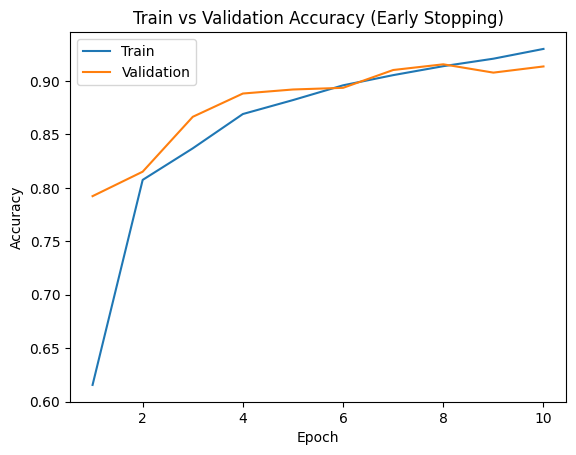

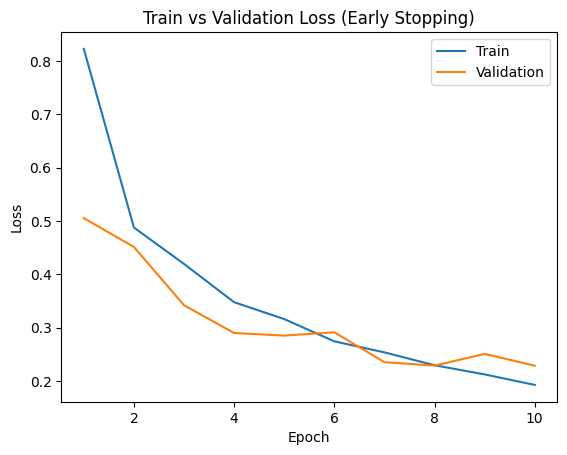

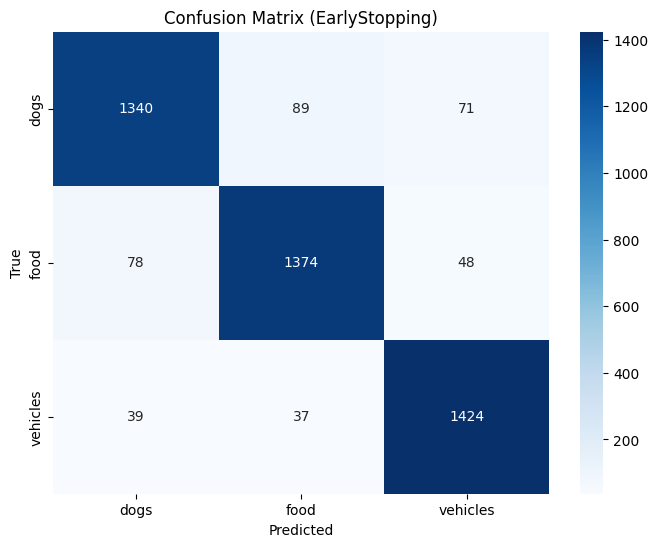

EarlyStopping - Precision: 0.9195, Recall: 0.9196, F1 Score: 0.9194


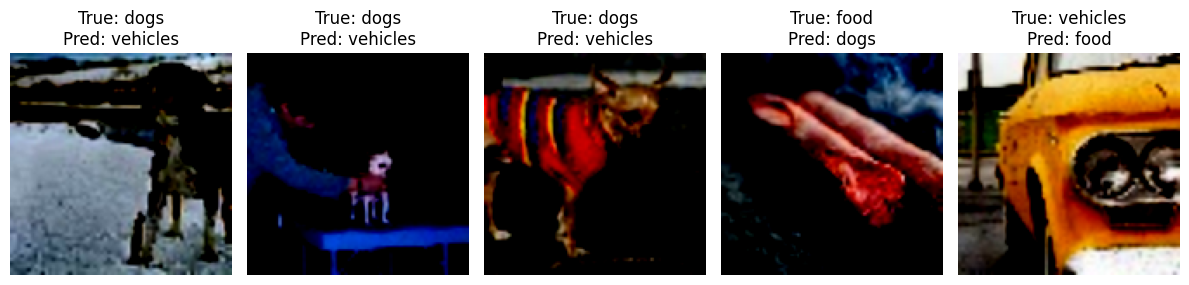

In [ ]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("\n=== Experiment 2: Early Stopping Only ===")
basic_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
train_dataset.transform = basic_transform
model_es = VGG_16_model(num_classes=num_classes).to(device)
model_es.apply(kaiming)
optimizer_es = optim.SGD(model_es.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_es = lr_scheduler.MultiStepLR(optimizer_es, milestones=[15, 25], gamma=0.1)
model_es, train_losses_es, train_accs_es, val_losses_es, val_accs_es = train_with_early_stopping_method(
    model_es, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_es, scheduler_es, device, num_epochs=10, patience=3
)
test_loss_es, test_acc_es, all_labels_es, all_preds_es = test_model_with_all_the_metrics(model_es, test_loader, nn.CrossEntropyLoss(), device)
print(f"(Early Stopping) Test Loss: {test_loss_es:.4f}, Test Acc: {test_acc_es:.4f}")
epochs_range_es = range(1, len(train_losses_es)+1)
plot_training(epochs_range_es, train_accs_es, val_accs_es, "Accuracy", "Train vs Validation Accuracy (Early Stopping)", "earlystop_accuracy_plot.svg")
plot_training(epochs_range_es, train_losses_es, val_losses_es, "Loss", "Train vs Validation Loss (Early Stopping)", "earlystop_loss_plot.svg")
plot_confusion(all_labels_es, all_preds_es, "EarlyStopping")
show_misclassified_images(model_es, test_loader, device, "EarlyStopping")


=== Experiment 3: Mixup Only ===
(Mixup) Epoch 1/10 -- Train Loss: 0.9636, Train Acc: 0.5392, Val Loss: 0.7460, Val Acc: 0.6651
(Mixup) Epoch 2/10 -- Train Loss: 0.7834, Train Acc: 0.6711, Val Loss: 0.5309, Val Acc: 0.8009
(Mixup) Epoch 3/10 -- Train Loss: 0.7279, Train Acc: 0.7038, Val Loss: 0.4390, Val Acc: 0.8382
(Mixup) Epoch 4/10 -- Train Loss: 0.6878, Train Acc: 0.7268, Val Loss: 0.3882, Val Acc: 0.8698
(Mixup) Epoch 5/10 -- Train Loss: 0.6654, Train Acc: 0.7370, Val Loss: 0.3712, Val Acc: 0.8818
(Mixup) Epoch 6/10 -- Train Loss: 0.6531, Train Acc: 0.7454, Val Loss: 0.3302, Val Acc: 0.9011
(Mixup) Epoch 7/10 -- Train Loss: 0.6358, Train Acc: 0.7535, Val Loss: 0.3676, Val Acc: 0.8822
(Mixup) Epoch 8/10 -- Train Loss: 0.6211, Train Acc: 0.7586, Val Loss: 0.3197, Val Acc: 0.8913
(Mixup) Epoch 9/10 -- Train Loss: 0.6121, Train Acc: 0.7626, Val Loss: 0.3404, Val Acc: 0.9147
(Mixup) Epoch 10/10 -- Train Loss: 0.6052, Train Acc: 0.7673, Val Loss: 0.2935, Val Acc: 0.9178
(Mixup) Test Lo

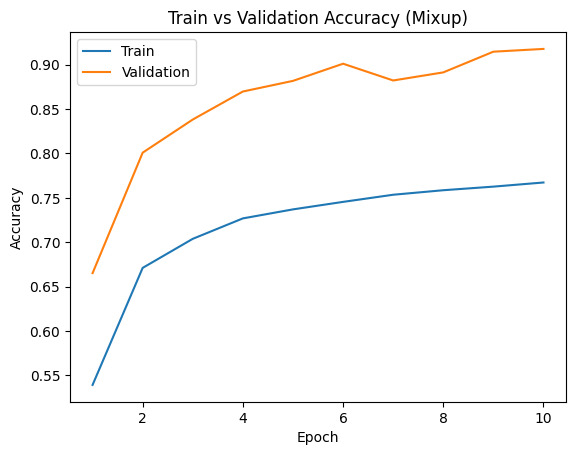

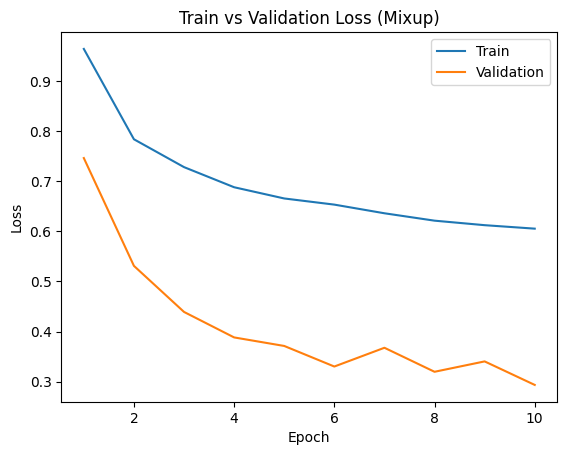

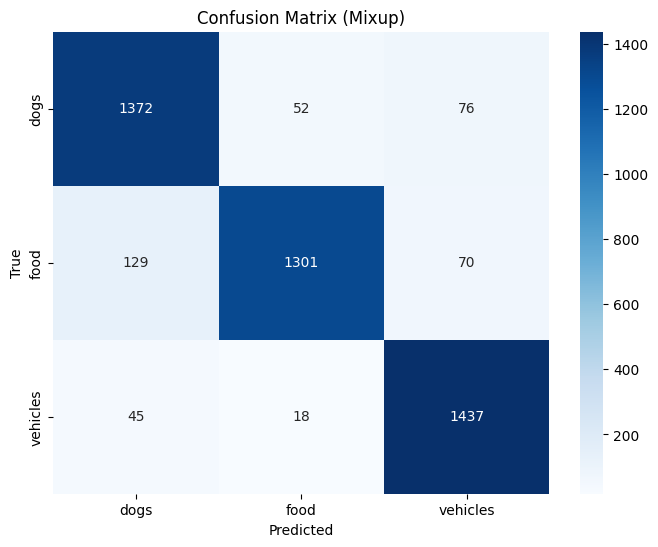

Mixup - Precision: 0.9147, Recall: 0.9133, F1 Score: 0.9131


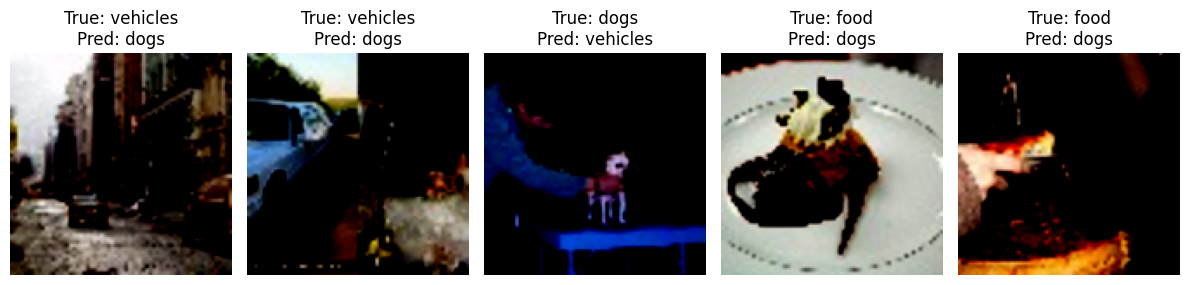

In [ ]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("\n=== Experiment 3: Mixup Only ===")
train_dataset.transform = basic_transform
model_mix = VGG_16_model(num_classes=num_classes).to(device)
model_mix.apply(kaiming)
optimizer_mix = optim.SGD(model_mix.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_mix = lr_scheduler.MultiStepLR(optimizer_mix, milestones=[15, 25], gamma=0.1)
model_mix, train_losses_mix, train_accs_mix, val_losses_mix, val_accs_mix = train_with_mixup_method(
    model_mix, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_mix, scheduler_mix, device, num_epochs=10, mixup_alpha=1.0
)
test_loss_mix, test_acc_mix, all_labels_mix, all_preds_mix = test_model_with_all_the_metrics(model_mix, test_loader, nn.CrossEntropyLoss(), device)
print(f"(Mixup) Test Loss: {test_loss_mix:.4f}, Test Acc: {test_acc_mix:.4f}")
epochs_range_mix = range(1, len(train_losses_mix)+1)
plot_training(epochs_range_mix, train_accs_mix, val_accs_mix, "Accuracy", "Train vs Validation Accuracy (Mixup)", "mixup_accuracy_plot.svg")
plot_training(epochs_range_mix, train_losses_mix, val_losses_mix, "Loss", "Train vs Validation Loss (Mixup)", "mixup_loss_plot.svg")
plot_confusion(all_labels_mix, all_preds_mix, "Mixup")
show_misclassified_images(model_mix, test_loader, device, "Mixup")

5. Evaluation and analysis.

6. Save the weights of the trained network.


=== Final Model: Early Stopping Only ===
(EarlyStopping) Epoch 1/10 -- Train Loss: 0.7755, Train Acc: 0.6362, Val Loss: 0.5077, Val Acc: 0.7993
(EarlyStopping) Epoch 2/10 -- Train Loss: 0.5065, Train Acc: 0.8005, Val Loss: 0.4269, Val Acc: 0.8267
(EarlyStopping) Epoch 3/10 -- Train Loss: 0.4191, Train Acc: 0.8383, Val Loss: 0.3791, Val Acc: 0.8640
(EarlyStopping) Epoch 4/10 -- Train Loss: 0.3615, Train Acc: 0.8608, Val Loss: 0.3163, Val Acc: 0.8822
(EarlyStopping) Epoch 5/10 -- Train Loss: 0.3146, Train Acc: 0.8822, Val Loss: 0.2965, Val Acc: 0.8842
(EarlyStopping) Epoch 6/10 -- Train Loss: 0.2837, Train Acc: 0.8918, Val Loss: 0.2784, Val Acc: 0.8924
(EarlyStopping) Epoch 7/10 -- Train Loss: 0.2521, Train Acc: 0.9047, Val Loss: 0.3437, Val Acc: 0.8756
(EarlyStopping) Epoch 8/10 -- Train Loss: 0.2334, Train Acc: 0.9118, Val Loss: 0.2580, Val Acc: 0.9051
(EarlyStopping) Epoch 9/10 -- Train Loss: 0.2031, Train Acc: 0.9230, Val Loss: 0.3172, Val Acc: 0.8851
(EarlyStopping) Epoch 10/10 -- 

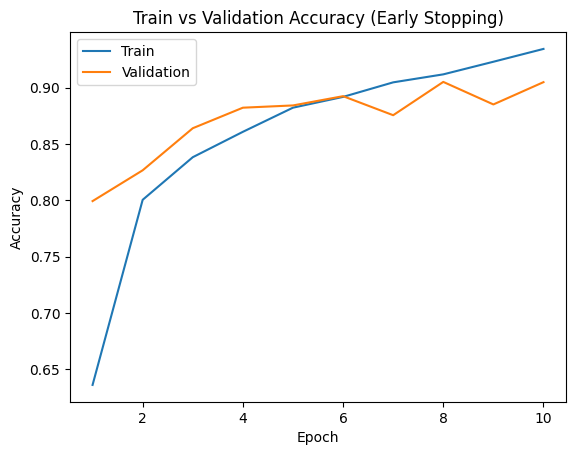

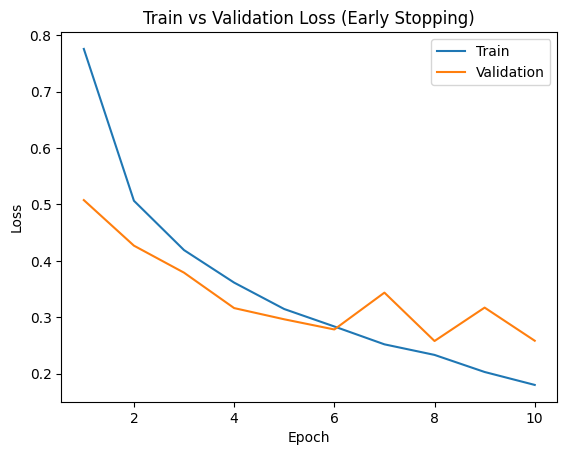

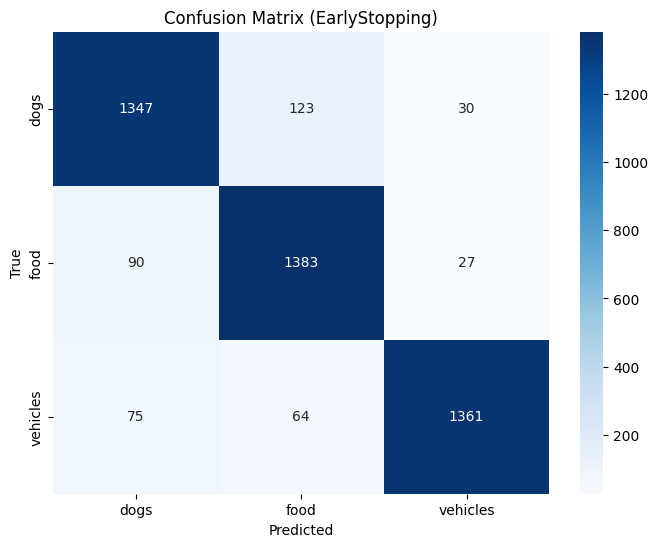

EarlyStopping - Precision: 0.9105, Recall: 0.9091, F1 Score: 0.9094


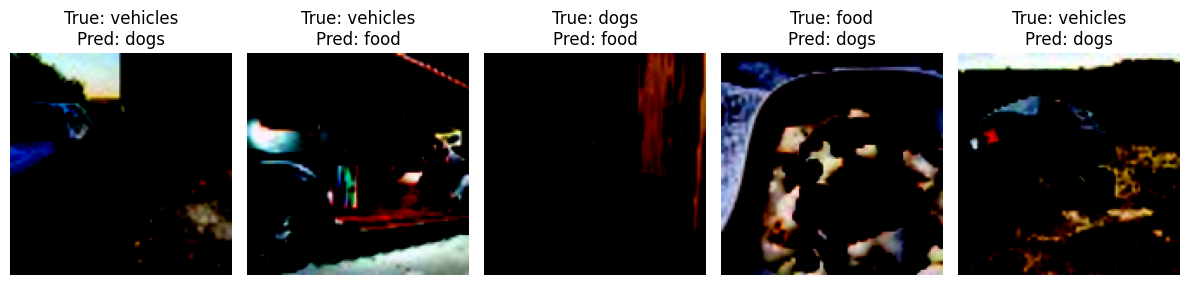

In [51]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("\n=== Final Model: Early Stopping Only ===")
basic_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
train_dataset.transform = basic_transform
model_es = VGG_16_model(num_classes=num_classes).to(device)
model_es.apply(xavier)
optimizer_es = optim.SGD(model_es.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_es = lr_scheduler.MultiStepLR(optimizer_es, milestones=[15, 25], gamma=0.1)
model_es, train_losses_es_vgg, train_accs_es_vgg, val_losses_es_vgg, val_accs_es_vgg = train_with_early_stopping_method(
    model_es, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_es, scheduler_es, device, num_epochs=10, patience=3
)
test_loss_es_vgg, test_acc_es_vgg, all_labels_es, all_preds_es = test_model_with_all_the_metrics(model_es, test_loader, nn.CrossEntropyLoss(), device)
print(f"(Early Stopping) Test Loss: {test_loss_es_vgg:.4f}, Test Acc: {test_acc_es_vgg:.4f}")
torch.save(model_es.state_dict(), "earlystopping_model_weights.pth")
print("Model weights saved to earlystopping_model_weights.pth")
epochs_range_es = range(1, len(train_losses_es_vgg)+1)
plot_training(epochs_range_es, train_accs_es_vgg, val_accs_es_vgg, "Accuracy", "Train vs Validation Accuracy (Early Stopping)", "earlystop_accuracy_plot.svg")
plot_training(epochs_range_es, train_losses_es_vgg, val_losses_es_vgg, "Loss", "Train vs Validation Loss (Early Stopping)", "earlystop_loss_plot.svg")
plot_confusion(all_labels_es, all_preds_es, "EarlyStopping")
show_misclassified_images(model_es, test_loader, device, "EarlyStopping")


The above graphs show that the VGG model steadily improves on both the training and validation sets over 10 epochs. The train vs. validation accuracy plot reveals a smooth climb in training accuracy, with validation accuracy following closely, indicating that the model is generalizing well rather than overfitting. Meanwhile, the train vs. validation loss plot shows both losses decreasing at a similar pace, with the validation loss only slightly higher than the training loss. Overall, the curves confirm that early stopping helps maintain a balance between learning effectively from the training data and preserving strong performance on unseen validation data.

In this confusion matrix, the model generally distinguishes the three classes well, but there are a few notable confusions. Dogs and food appear to be the most frequently misclassified pair, with 123 `dog images` labeled as food and 90 food images labeled as dogs. Meanwhile, vehicles are occasionally confused with dogs (75 cases) and food (64 cases), though these misclassifications are somewhat fewer. Overall, the precision of 0.9105, recall of 0.9091, and F1 score of 0.9094 confirm that the model is performing at a consistently high level across all classes. The close alignment of precision and recall also suggests balanced performance, indicating that the network does not excessively favor any single class and is reliably identifying correct labels for the majority of examples.

These misclassifications seem driven by the dark lighting and low contrast in each scene, making it hard for the model to distinguish clear outlines or textures. Vehicles in near‐pitch‐black conditions might resemble the vague shapes of dogs or even lumps of food, especially when color cues are missing. Similarly, the dog images are too dim for the network to pick out fur patterns or facial features. This highlights how limited visibility can lead the model to rely on misleading or insufficient cues, causing it to predict the wrong class.

In [61]:
print(train_losses_es_vgg)
print(train_accs_es_vgg)
print(val_losses_es_vgg)
print(val_accs_es_vgg)

[0.7755079404058911, 0.5064942116623833, 0.41907461838495164, 0.361461782909575, 0.31463205218315127, 0.2837349299788475, 0.2520964642649605, 0.23336114595617566, 0.2031063601516542, 0.1801866364308766]
[0.6361904761904762, 0.8004761904761905, 0.8382857142857143, 0.8608095238095238, 0.8822380952380953, 0.8918095238095238, 0.9047142857142857, 0.9118095238095238, 0.923, 0.9343809523809524]
[0.5076592330932617, 0.4269339513513777, 0.37907193125618827, 0.3163323191271888, 0.2964695050186581, 0.2784410022629632, 0.3436990509298113, 0.2579884813692835, 0.3171757252679931, 0.2584740707145797]
[0.7993333333333333, 0.8266666666666667, 0.864, 0.8822222222222222, 0.8842222222222222, 0.8924444444444445, 0.8755555555555556, 0.9051111111111112, 0.8851111111111112, 0.904888888888889]


## Step 3: Implementing ResNet

In [43]:
                                    ##-----------------------------##
                                    # Sets seed for reproducibility #
                                    ##-----------------------------##

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

1. Implement residual blocks of ResNet.

In [36]:
#Initialize the residual block as a class
class ResBlock(nn.Module):

    expansion = 1                             #Used for knowing the output dim in multi-layers

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,       #1st Conv Layer
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x                                      #Saves input for residual connection

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        #Case were dimension differs
        if self.downsample is not None:
            identity = self.downsample(x)

        #The Residual connection
        out += identity
        out = self.relu(out)
        return out

2. Assemble the ResNet-18 architecture.

In [37]:
                        ##--------------------------------------------------------##
                        # Create the Resnet architecture using the residual blocks #
                        ##--------------------------------------------------------##

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3, init_method='he'):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.init_method = init_method

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        #Helps initialize weights instead of random initialization
        self._initialize_weights()

    def _make_layer(self, block, out_channels, blocks, stride):

        downsample = None              #Helps downsample if the input and output dimensions does not match
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    #Based on input type mentioned initializes weights instead of random weight init
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if self.init_method == 'he':
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                elif self.init_method == 'xavier':
                    nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #Passes through the four layers of residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18(num_classes=3, init_method='he'):
    return ResNet(ResBlock, [2, 2, 2, 2], num_classes=num_classes, init_method=init_method)

3. Train the ResNet-18 model.

In [38]:
#Helper functions to train the model in a loop

#Helps take the optimizer for init
def get_optimizer(model, optimizer_name, lr):
    if optimizer_name.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")


#Main train, test modularized function
def train_and_evaluate(model, train_loader, val_loader, device, config, exp_id):

    writer = SummaryWriter(log_dir=f'runs/exp_{exp_id}_{time.strftime("%Y%m%d-%H%M%S")}')
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, config['optimizer'], config['learning_rate'])
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config['lr_step'], gamma=config['lr_gamma'])

    model = model.to(device)
    best_val_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(config['num_epochs']):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        #Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = running_loss / total
        val_acc = correct / total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)

        print(f"Exp {exp_id} | Epoch {epoch+1}/{config['num_epochs']} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        scheduler.step()

    writer.close()

    #Test set eval
    model.eval()
    test_running_loss = 0.0
    correct = 0
    total = 0
    test_all_preds = []
    test_all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            test_all_preds.extend(preds.cpu().numpy())
            test_all_labels.extend(labels.cpu().numpy())
    test_loss = test_running_loss / total
    test_acc = correct / total
    test_cm = confusion_matrix(test_all_labels, test_all_preds)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_all_labels, test_all_preds, average='weighted')
    test_misclassified = total - sum(np.array(test_all_preds) == np.array(test_all_labels))
    print(f"\nExp {exp_id} Test Set Evaluation:")
    print(f"Test Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")
    print(f"Confusion Matrix:\n{test_cm}")
    print(f"Precision: {test_precision:.4f}  Recall: {test_recall:.4f}  F1: {test_f1:.4f}")
    print(f"Misclassified: {test_misclassified}/{total}")

    return {
        'history': history,
        'test_loss': test_loss,
        'test_acc': test_acc
    }

In [ ]:
#A global config file
global_config = {
        'num_epochs': 10,
        'learning_rate': 0.001,
        'lr_step': 7,
        'lr_gamma': 0.1
    }

#Hyperparameters to loop over
weight_inits = ['he', 'xavier']
optimizers = ['sgd', 'adam', 'rmsprop']
batch_sizes = [32, 64]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

experiment_results = {}
exp_counter = 1

for init_method, optimizer_name, batch_size in product(weight_inits, optimizers, batch_sizes):
    exp_id = f"exp{exp_counter}-{init_method}_opt-{optimizer_name}_bs-{batch_size}"
    print(f"\nStarting {exp_id}")

    config = global_config.copy()
    config['init_method'] = init_method
    config['optimizer'] = optimizer_name
    config['batch_size'] = batch_size

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    model = resnet18(num_classes=3, init_method=init_method)

    result = train_and_evaluate(model, train_loader, val_loader, device, config, exp_id)
    experiment_results[exp_id] = result
    exp_counter += 1

Using device: cuda

Starting exp1-he_opt-sgd_bs-32
Exp exp1-he_opt-sgd_bs-32 | Epoch 1/10 | Train Loss: 0.5167 Acc: 0.7925 | Val Loss: 0.4212 Acc: 0.8409
Exp exp1-he_opt-sgd_bs-32 | Epoch 2/10 | Train Loss: 0.3789 Acc: 0.8530 | Val Loss: 0.3394 Acc: 0.8718
Exp exp1-he_opt-sgd_bs-32 | Epoch 3/10 | Train Loss: 0.3295 Acc: 0.8752 | Val Loss: 0.3086 Acc: 0.8873
Exp exp1-he_opt-sgd_bs-32 | Epoch 4/10 | Train Loss: 0.2912 Acc: 0.8910 | Val Loss: 0.3756 Acc: 0.8538
Exp exp1-he_opt-sgd_bs-32 | Epoch 5/10 | Train Loss: 0.2702 Acc: 0.8981 | Val Loss: 0.2690 Acc: 0.8982
Exp exp1-he_opt-sgd_bs-32 | Epoch 6/10 | Train Loss: 0.2491 Acc: 0.9065 | Val Loss: 0.3064 Acc: 0.8909
Exp exp1-he_opt-sgd_bs-32 | Epoch 7/10 | Train Loss: 0.2225 Acc: 0.9187 | Val Loss: 0.2453 Acc: 0.9149
Exp exp1-he_opt-sgd_bs-32 | Epoch 8/10 | Train Loss: 0.1755 Acc: 0.9357 | Val Loss: 0.2034 Acc: 0.9271
Exp exp1-he_opt-sgd_bs-32 | Epoch 9/10 | Train Loss: 0.1655 Acc: 0.9411 | Val Loss: 0.2004 Acc: 0.9267
Exp exp1-he_opt-sgd_bs

Exp exp7-xavier_opt-sgd_bs-32 | Epoch 4/10 | Train Loss: 0.2778 Acc: 0.8982 | Val Loss: 0.2978 Acc: 0.8924
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 5/10 | Train Loss: 0.2496 Acc: 0.9067 | Val Loss: 0.2413 Acc: 0.9087
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 6/10 | Train Loss: 0.2251 Acc: 0.9177 | Val Loss: 0.3046 Acc: 0.8873
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 7/10 | Train Loss: 0.2013 Acc: 0.9279 | Val Loss: 0.2769 Acc: 0.9016
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 8/10 | Train Loss: 0.1454 Acc: 0.9478 | Val Loss: 0.1820 Acc: 0.9322
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 9/10 | Train Loss: 0.1336 Acc: 0.9530 | Val Loss: 0.1683 Acc: 0.9376
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 10/10 | Train Loss: 0.1301 Acc: 0.9558 | Val Loss: 0.1693 Acc: 0.9398

Exp exp7-xavier_opt-sgd_bs-32 Test Set Evaluation:
Test Loss: 0.1562  Test Acc: 0.9416
Confusion Matrix:
[[1431   43   26]
 [  77 1396   27]
 [  58   32 1410]]
Precision: 0.9422  Recall: 0.9416  F1: 0.9417
Misclassified: 263/4500

Starting exp8-xavi

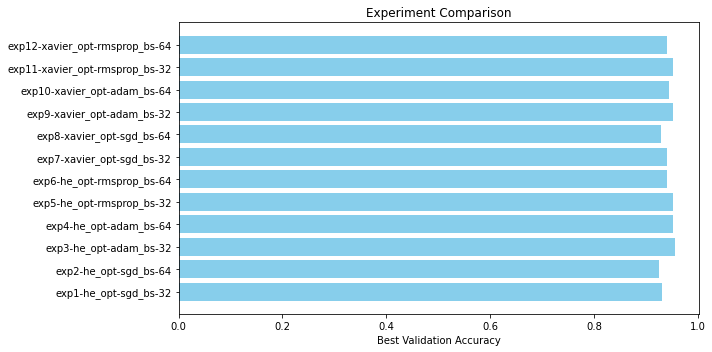


Summary of experiments:
exp1-he_opt-sgd_bs-32: Test Loss = 0.1824, Test Acc = 0.9320
exp2-he_opt-sgd_bs-64: Test Loss = 0.2072, Test Acc = 0.9253
exp3-he_opt-adam_bs-32: Test Loss = 0.1242, Test Acc = 0.9556
exp4-he_opt-adam_bs-64: Test Loss = 0.1359, Test Acc = 0.9520
exp5-he_opt-rmsprop_bs-32: Test Loss = 0.1328, Test Acc = 0.9520
exp6-he_opt-rmsprop_bs-64: Test Loss = 0.1634, Test Acc = 0.9402
exp7-xavier_opt-sgd_bs-32: Test Loss = 0.1562, Test Acc = 0.9416
exp8-xavier_opt-sgd_bs-64: Test Loss = 0.1912, Test Acc = 0.9296
exp9-xavier_opt-adam_bs-32: Test Loss = 0.1319, Test Acc = 0.9533
exp10-xavier_opt-adam_bs-64: Test Loss = 0.1476, Test Acc = 0.9456
exp11-xavier_opt-rmsprop_bs-32: Test Loss = 0.1433, Test Acc = 0.9518
exp12-xavier_opt-rmsprop_bs-64: Test Loss = 0.1647, Test Acc = 0.9402


In [ ]:
exp_ids = list(experiment_results.keys())
best_accs = [experiment_results[exp]['test_acc'] for exp in exp_ids]
plt.figure(figsize=(10, 5))
plt.barh(exp_ids, best_accs, color='skyblue')
plt.xlabel('Best Validation Accuracy')
plt.title('Experiment Comparison')
plt.tight_layout()
plt.show()

print("\nSummary of experiments:")
for exp_id, res in experiment_results.items():
    print(f"{exp_id}: Test Loss = {res['test_loss']:.4f}, Test Acc = {res['test_acc']:.4f}")

### `Best Results:`
`exp3-he_opt-adam_bs-32:` Test Loss = 0.1242, Test Acc = 0.9556

After succesful experiments, we found out ResNet with `He Initialization`, `Adam Optimizer` with a `batch size of 32`, gave us the most promising and best results overall. If observed, most of the 32 batch size experiments had a slight upper hand than the 64 ones, this is because of the model's ability to generalize better on the test set as for every 32 batch of images the internal parameters were updated. Thus, giving it better approximation on the data.

4. Apply regularization techniques.

Using device: cuda

Starting experiment: EarlyStopping
Exp ResNet_EarlyStopping | Epoch 1/15 - Train Loss: 0.4663, Train Acc: 0.8172, Val Loss: 0.3540, Val Acc: 0.8587
Exp ResNet_EarlyStopping | Epoch 2/15 - Train Loss: 0.3182, Train Acc: 0.8800, Val Loss: 0.4223, Val Acc: 0.8264
Exp ResNet_EarlyStopping | Epoch 3/15 - Train Loss: 0.2656, Train Acc: 0.9026, Val Loss: 0.2276, Val Acc: 0.9158
Exp ResNet_EarlyStopping | Epoch 4/15 - Train Loss: 0.2311, Train Acc: 0.9151, Val Loss: 0.2229, Val Acc: 0.9176
Exp ResNet_EarlyStopping | Epoch 5/15 - Train Loss: 0.2062, Train Acc: 0.9256, Val Loss: 0.1861, Val Acc: 0.9367
Exp ResNet_EarlyStopping | Epoch 6/15 - Train Loss: 0.1829, Train Acc: 0.9332, Val Loss: 0.1964, Val Acc: 0.9269
Exp ResNet_EarlyStopping | Epoch 7/15 - Train Loss: 0.1657, Train Acc: 0.9383, Val Loss: 0.1906, Val Acc: 0.9324
Exp ResNet_EarlyStopping | Epoch 8/15 - Train Loss: 0.1544, Train Acc: 0.9427, Val Loss: 0.2508, Val Acc: 0.9129
Exp ResNet_EarlyStopping | Epoch 9/15 - T

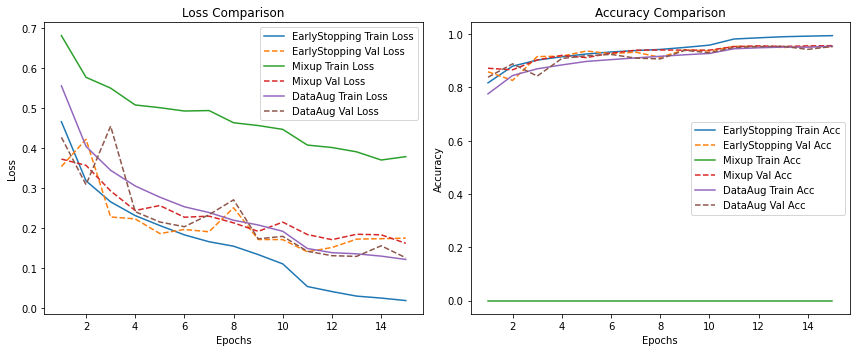

All experiments completed.


In [ ]:
                                        # --------------------------- #
                                        # Reg Tech 1: Early Stopping  #
                                        # --------------------------- #

class EarlyStopping:
    def __init__(self, patience=2, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
            return self.early_stop

                                        # --------------------------- #
                                        #       Reg Tech 2: Mixup     #
                                        # --------------------------- #


def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


                                        # ----------------------------- #
                                        # Reg Tech 3: Data Augmentation #
                                        # ----------------------------- #


def get_transforms(use_data_aug=False):
    if use_data_aug:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform


#Dataloaders
def get_data_loaders(dataset_dir, batch_size, use_data_aug=False):
    train_transform, test_transform = get_transforms(use_data_aug)
    full_dataset = datasets.ImageFolder(root=dataset_dir, transform=train_transform)
    indices = np.arange(len(full_dataset))
    train_idx, test_val_idx = train_test_split(indices, test_size=0.3,
                                                stratify=full_dataset.targets, random_state=42)
    val_idx, test_idx = train_test_split(test_val_idx, test_size=0.5,
                                         stratify=[full_dataset.targets[i] for i in test_val_idx], random_state=42)
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset_full = datasets.ImageFolder(root=dataset_dir, transform=test_transform)
    test_dataset_full = datasets.ImageFolder(root=dataset_dir, transform=test_transform)
    val_dataset = Subset(val_dataset_full, val_idx)
    test_dataset = Subset(test_dataset_full, test_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader, test_loader


def train_and_evaluate(model, train_loader, val_loader, test_loader, device, config, exp_id):
    writer = SummaryWriter(log_dir=f"runs/exp_{exp_id}_{time.strftime('%Y%m%d-%H%M%S')}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config['lr_step'], gamma=config['lr_gamma'])

    early_stopping = EarlyStopping(patience=config['patience']) if config['use_early_stopping'] else None

    model = model.to(device)
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(config['num_epochs']):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            if config['use_mixup']:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=config['mixup_alpha'], use_cuda=(device.type=='cuda'))
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            if not config['use_mixup']:
                correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss / total
        train_acc = correct / total if not config['use_mixup'] else 0
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)

        #Evaluate
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("Accuracy/Val", val_acc, epoch)

        print(f"Exp {exp_id} | Epoch {epoch+1}/{config['num_epochs']} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()

        if config['use_early_stopping']:
            if early_stopping(val_loss, model):
                print("Early stopping triggered.")
                break

    writer.close()

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    test_all_preds = []
    test_all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
            test_all_preds.extend(preds.cpu().numpy())
            test_all_labels.extend(labels.cpu().numpy())
    test_loss = test_running_loss / test_total
    test_acc = test_correct / test_total
    test_cm = confusion_matrix(test_all_labels, test_all_preds)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_all_labels, test_all_preds, average='weighted')
    print(f"\nTest Evaluation for Exp {exp_id}:")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(f"Confusion Matrix:\n{test_cm}")
    print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

    return history

base_config = {
    'num_epochs': 15,
    'learning_rate': 0.001,
    'lr_step': 10,
    'lr_gamma': 0.1,
    'dataset_dir': 'cnn_dataset',
    'batch_size': 32,
    'patience': 5,
    'mixup_alpha': 0.4
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

experiments = {
    "EarlyStopping": {
        **base_config,
        "use_early_stopping": True,
        "use_mixup": False,
        "use_data_aug": False
    },
    "Mixup": {
        **base_config,
        "use_early_stopping": False,
        "use_mixup": True,
        "use_data_aug": False
    },
    "DataAug": {
        **base_config,
        "use_early_stopping": False,
        "use_mixup": False,
        "use_data_aug": True
    }
}

results = {}

for exp_name, config in experiments.items():
    print(f"\nStarting experiment: {exp_name}")
    train_loader, val_loader, test_loader = get_data_loaders(config['dataset_dir'], config['batch_size'], use_data_aug=config['use_data_aug'])
    model = resnet18(num_classes=3, init_method='he')
    exp_id = f"ResNet_{exp_name}"
    history = train_and_evaluate(model, train_loader, val_loader, test_loader, device, config, exp_id)
    results[exp_name] = history
    print(f"Experiment {exp_name} completed.\n")


plt.figure(figsize=(12, 5))

#Plots the Loss Comparison
plt.subplot(1, 2, 1)
for exp_name, history in results.items():
    epochs = range(1, len(history['train_loss']) + 1)
    plt.plot(epochs, history['train_loss'], label=f"{exp_name} Train Loss")
    plt.plot(epochs, history['val_loss'], linestyle="--", label=f"{exp_name} Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()

#Plots the Accuracy Comparison
plt.subplot(1, 2, 2)
for exp_name, history in results.items():
    epochs = range(1, len(history['train_acc']) + 1)
    plt.plot(epochs, history['train_acc'], label=f"{exp_name} Train Acc")
    plt.plot(epochs, history['val_acc'], linestyle="--", label=f"{exp_name} Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()

plt.tight_layout()
plt.show()

### `Best Results (After Regularization):`
`ResNet_Mixup_init-he_opt-adam_bs-32_reg-mixup:` Test Loss: 0.1557, Test Acc: 0.9622

After applying 3 different regularization techniques, we ended with a higher accuracy than the base model using `mixup` of data as a regularization method. After observing the train loss and accuracy from the above plots, we can conclude that during the training period, the early stopping didn't help that much to generalize to the test sets, it instead overfitted model here because the number of epochs are really less to see its effectiveness. The same goes for data augmentation, it performed better than early stopping and showed very slight improvements.

Whereas, Mixup showed promising improvement in the test accuracy by better generalizing the data. If observed, the train acc is set to zero, this is because it's irrelevant as mixup creates mixes 2 or more class images and makes new classes. So, when observed it shows the highest train loss but this method helps generalize better due to its slight lesser confidence on the presented data, thus not ignoring multiple misclassified cases where the other models failed to do so.

# TensorBoard Visualization in Jupyter Notebook

Below are the TensorBoard charts for different experimental runs. If the images do not display, please ensure that the links are set to public sharing and provide direct image links.

## 1. Multiple Runs Comparison

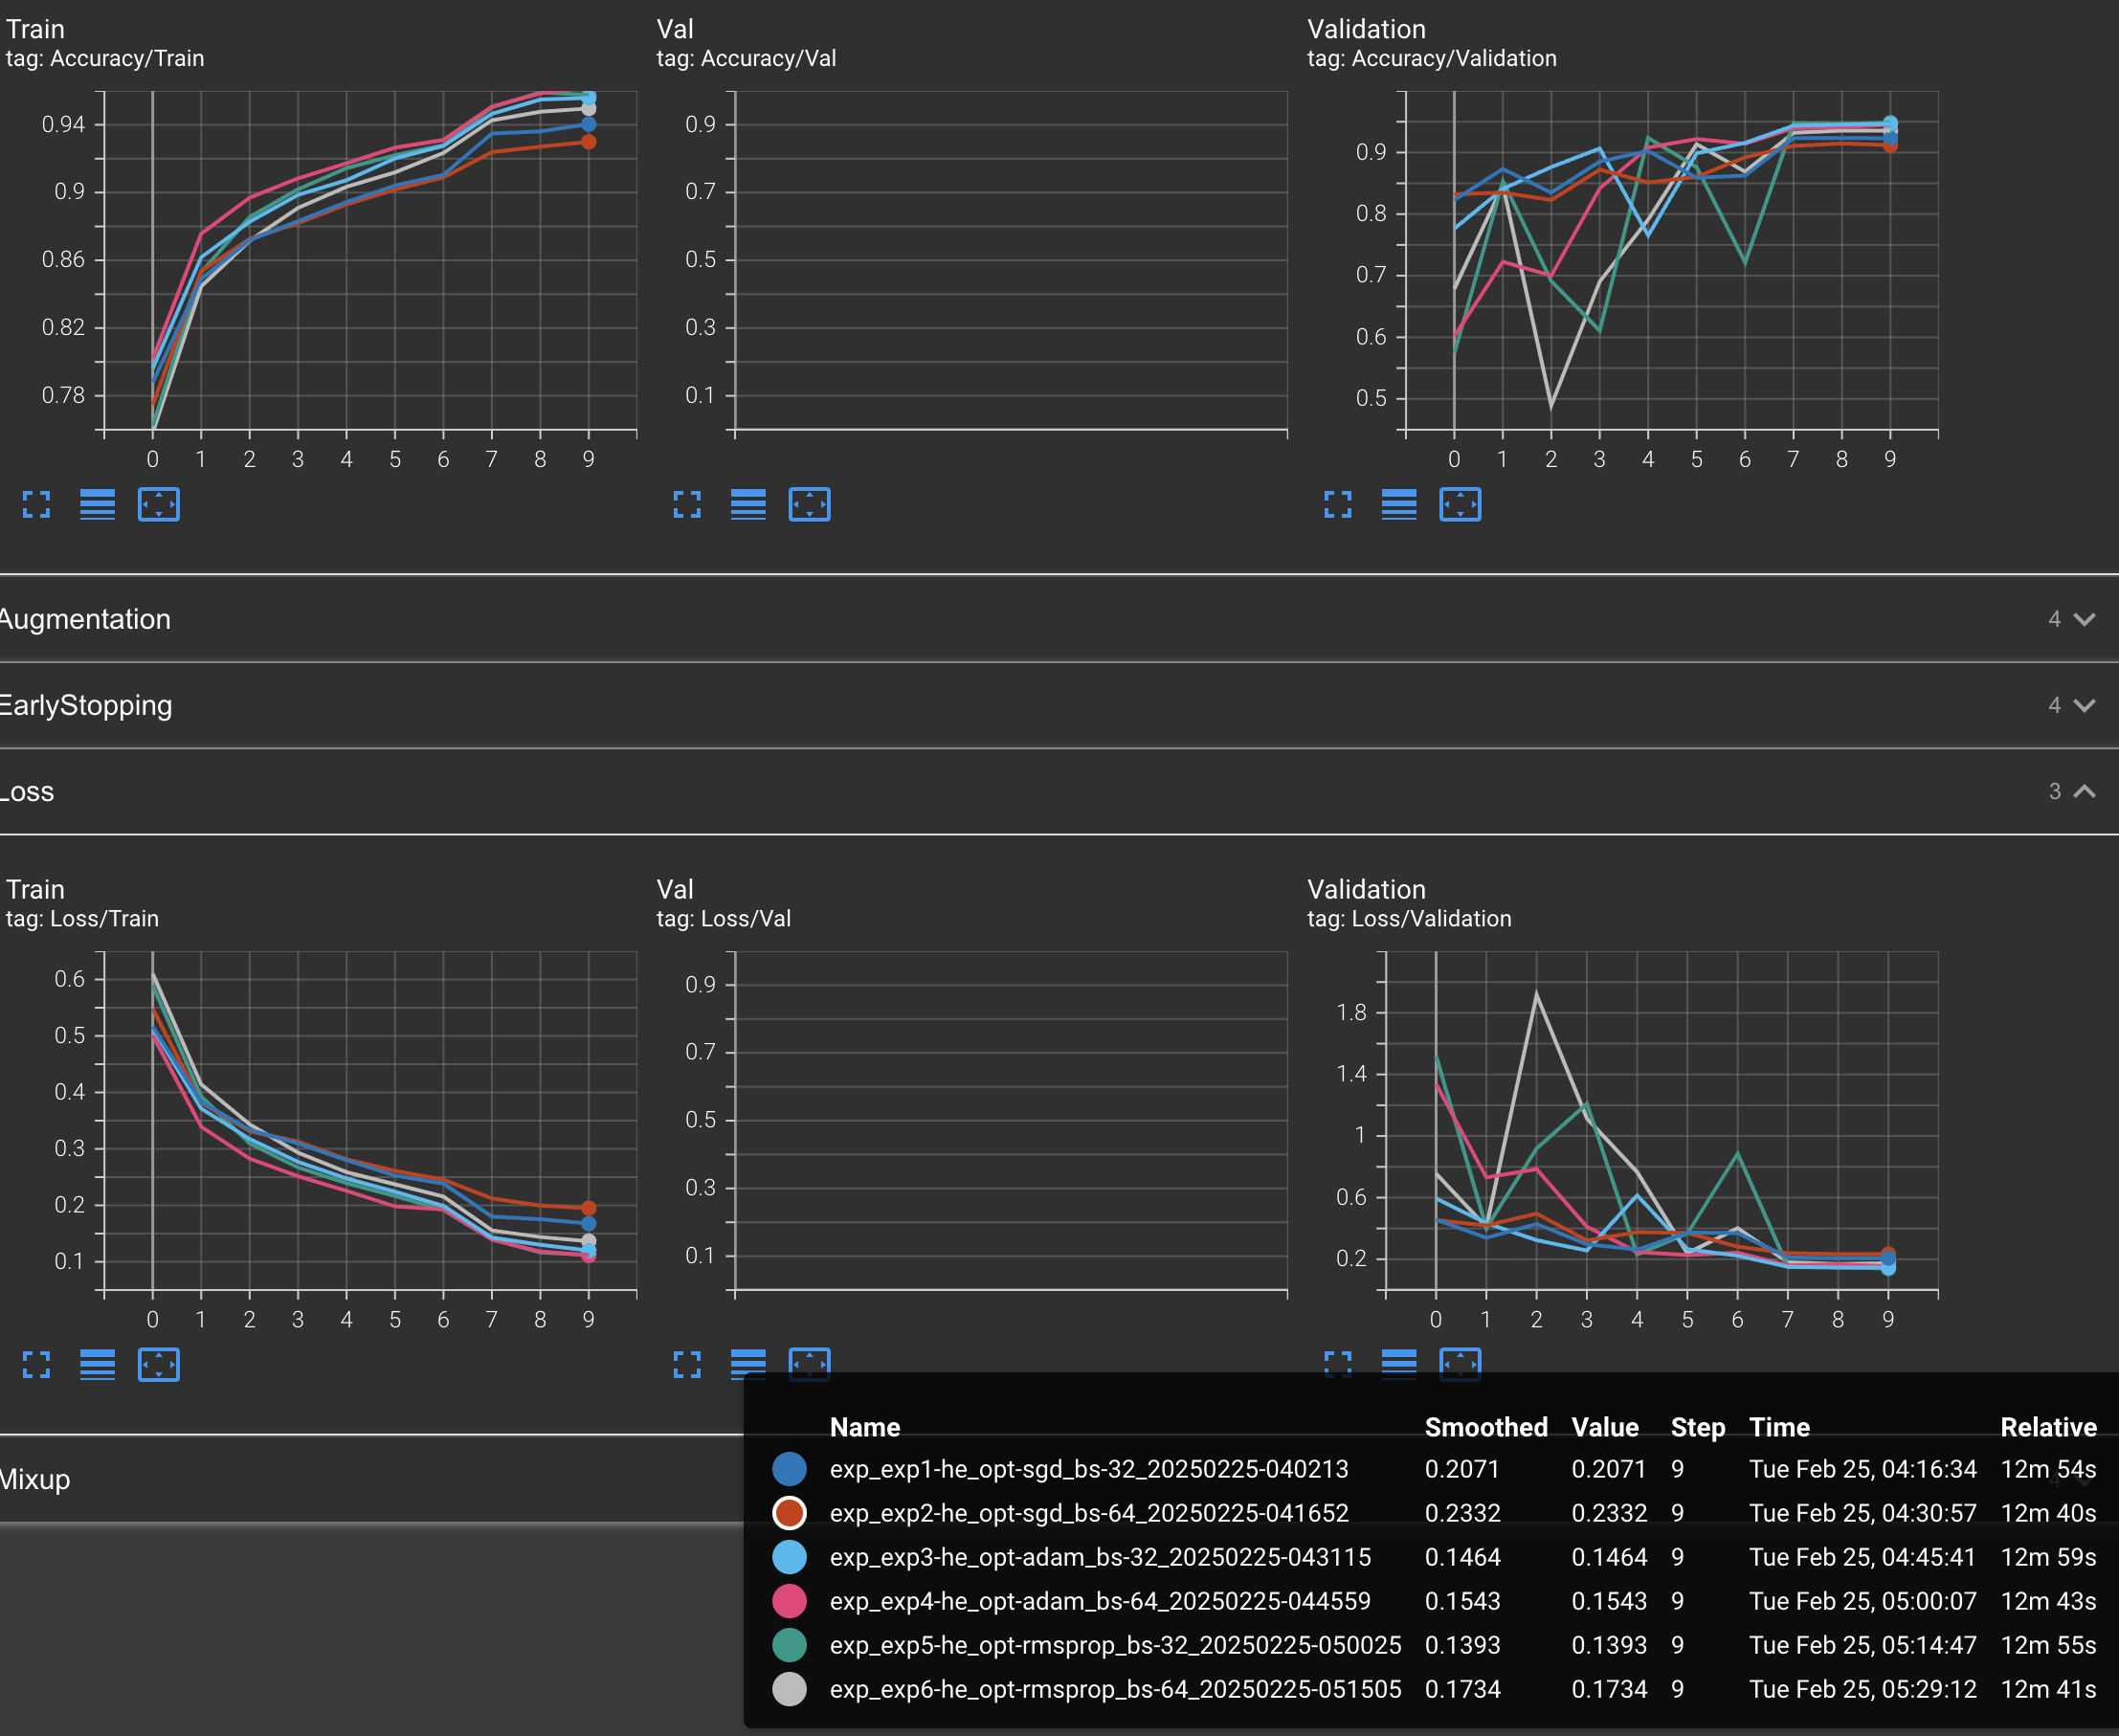

**Description:**  
This chart compares several runs (e.g., different optimizers, batch sizes, or initialization methods). Each curve represents a distinct configuration, and you can observe how the training and validation metrics vary across these runs.

---

## 2. Two Runs Comparison

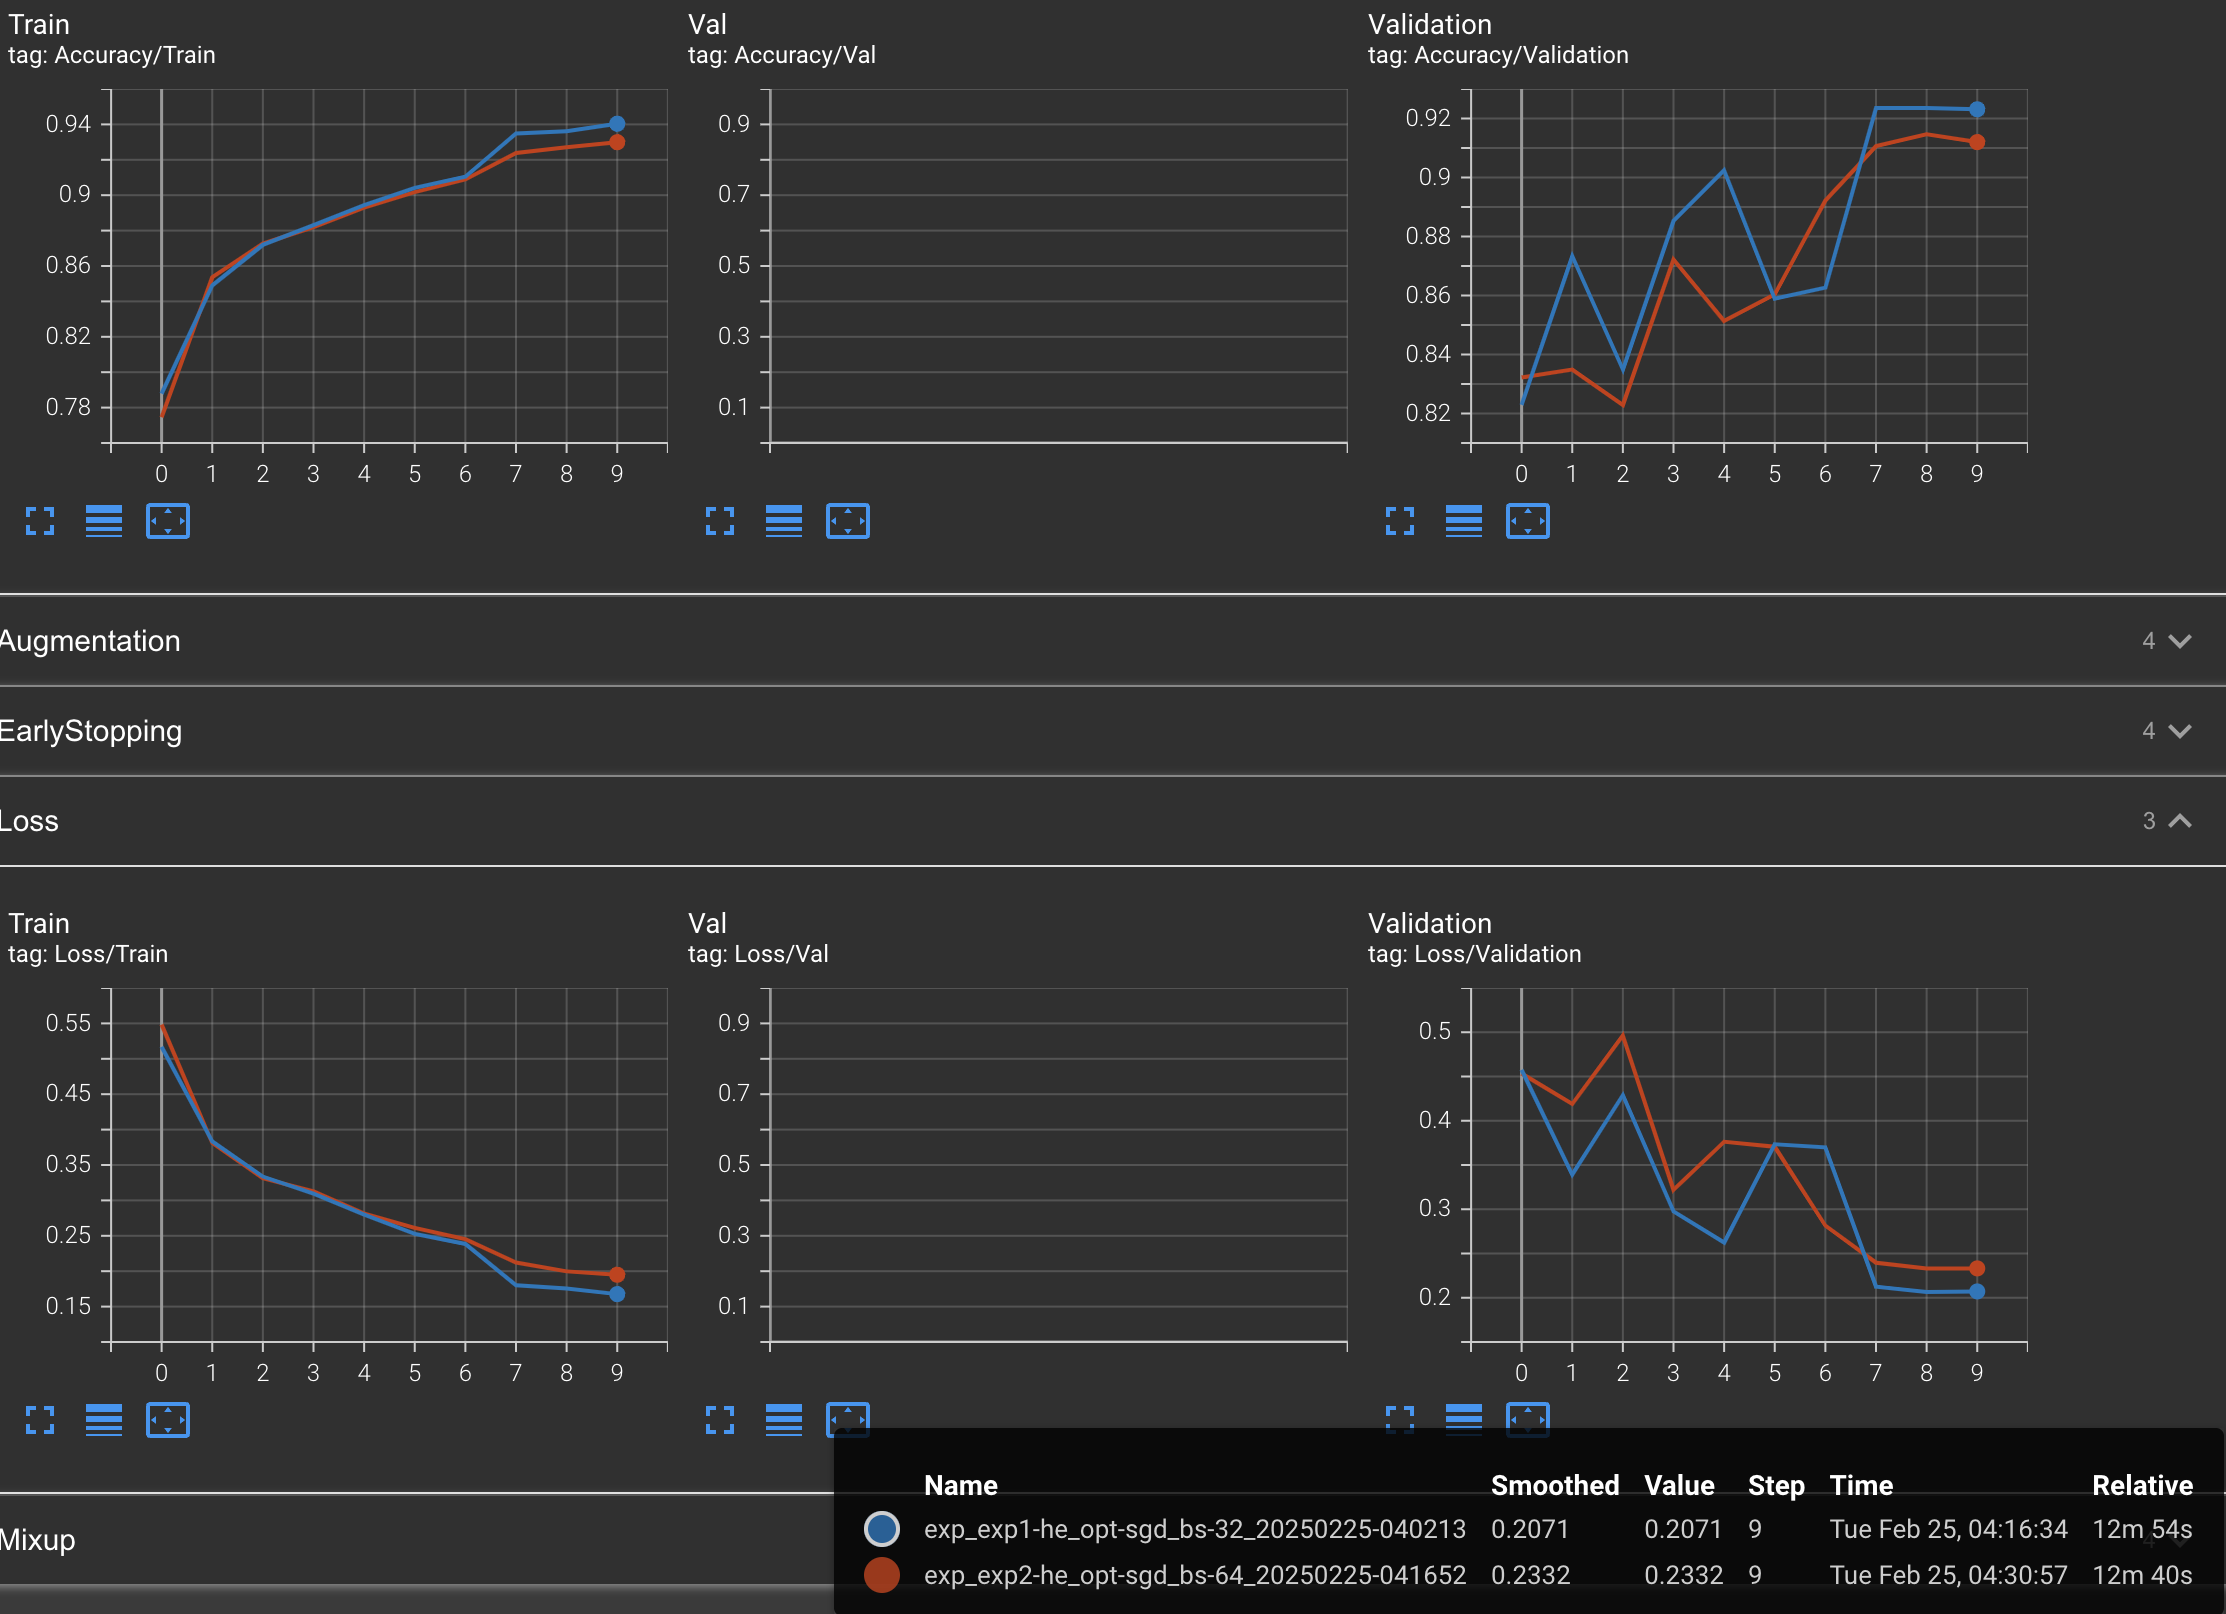

**Description:**  
This chart contrasts two experimental runs. It highlights the differences in accuracy and loss between the two configurations, making it easier to identify which hyperparameters contribute to better performance.

---

## 3. Single Run (Train vs. Validation)

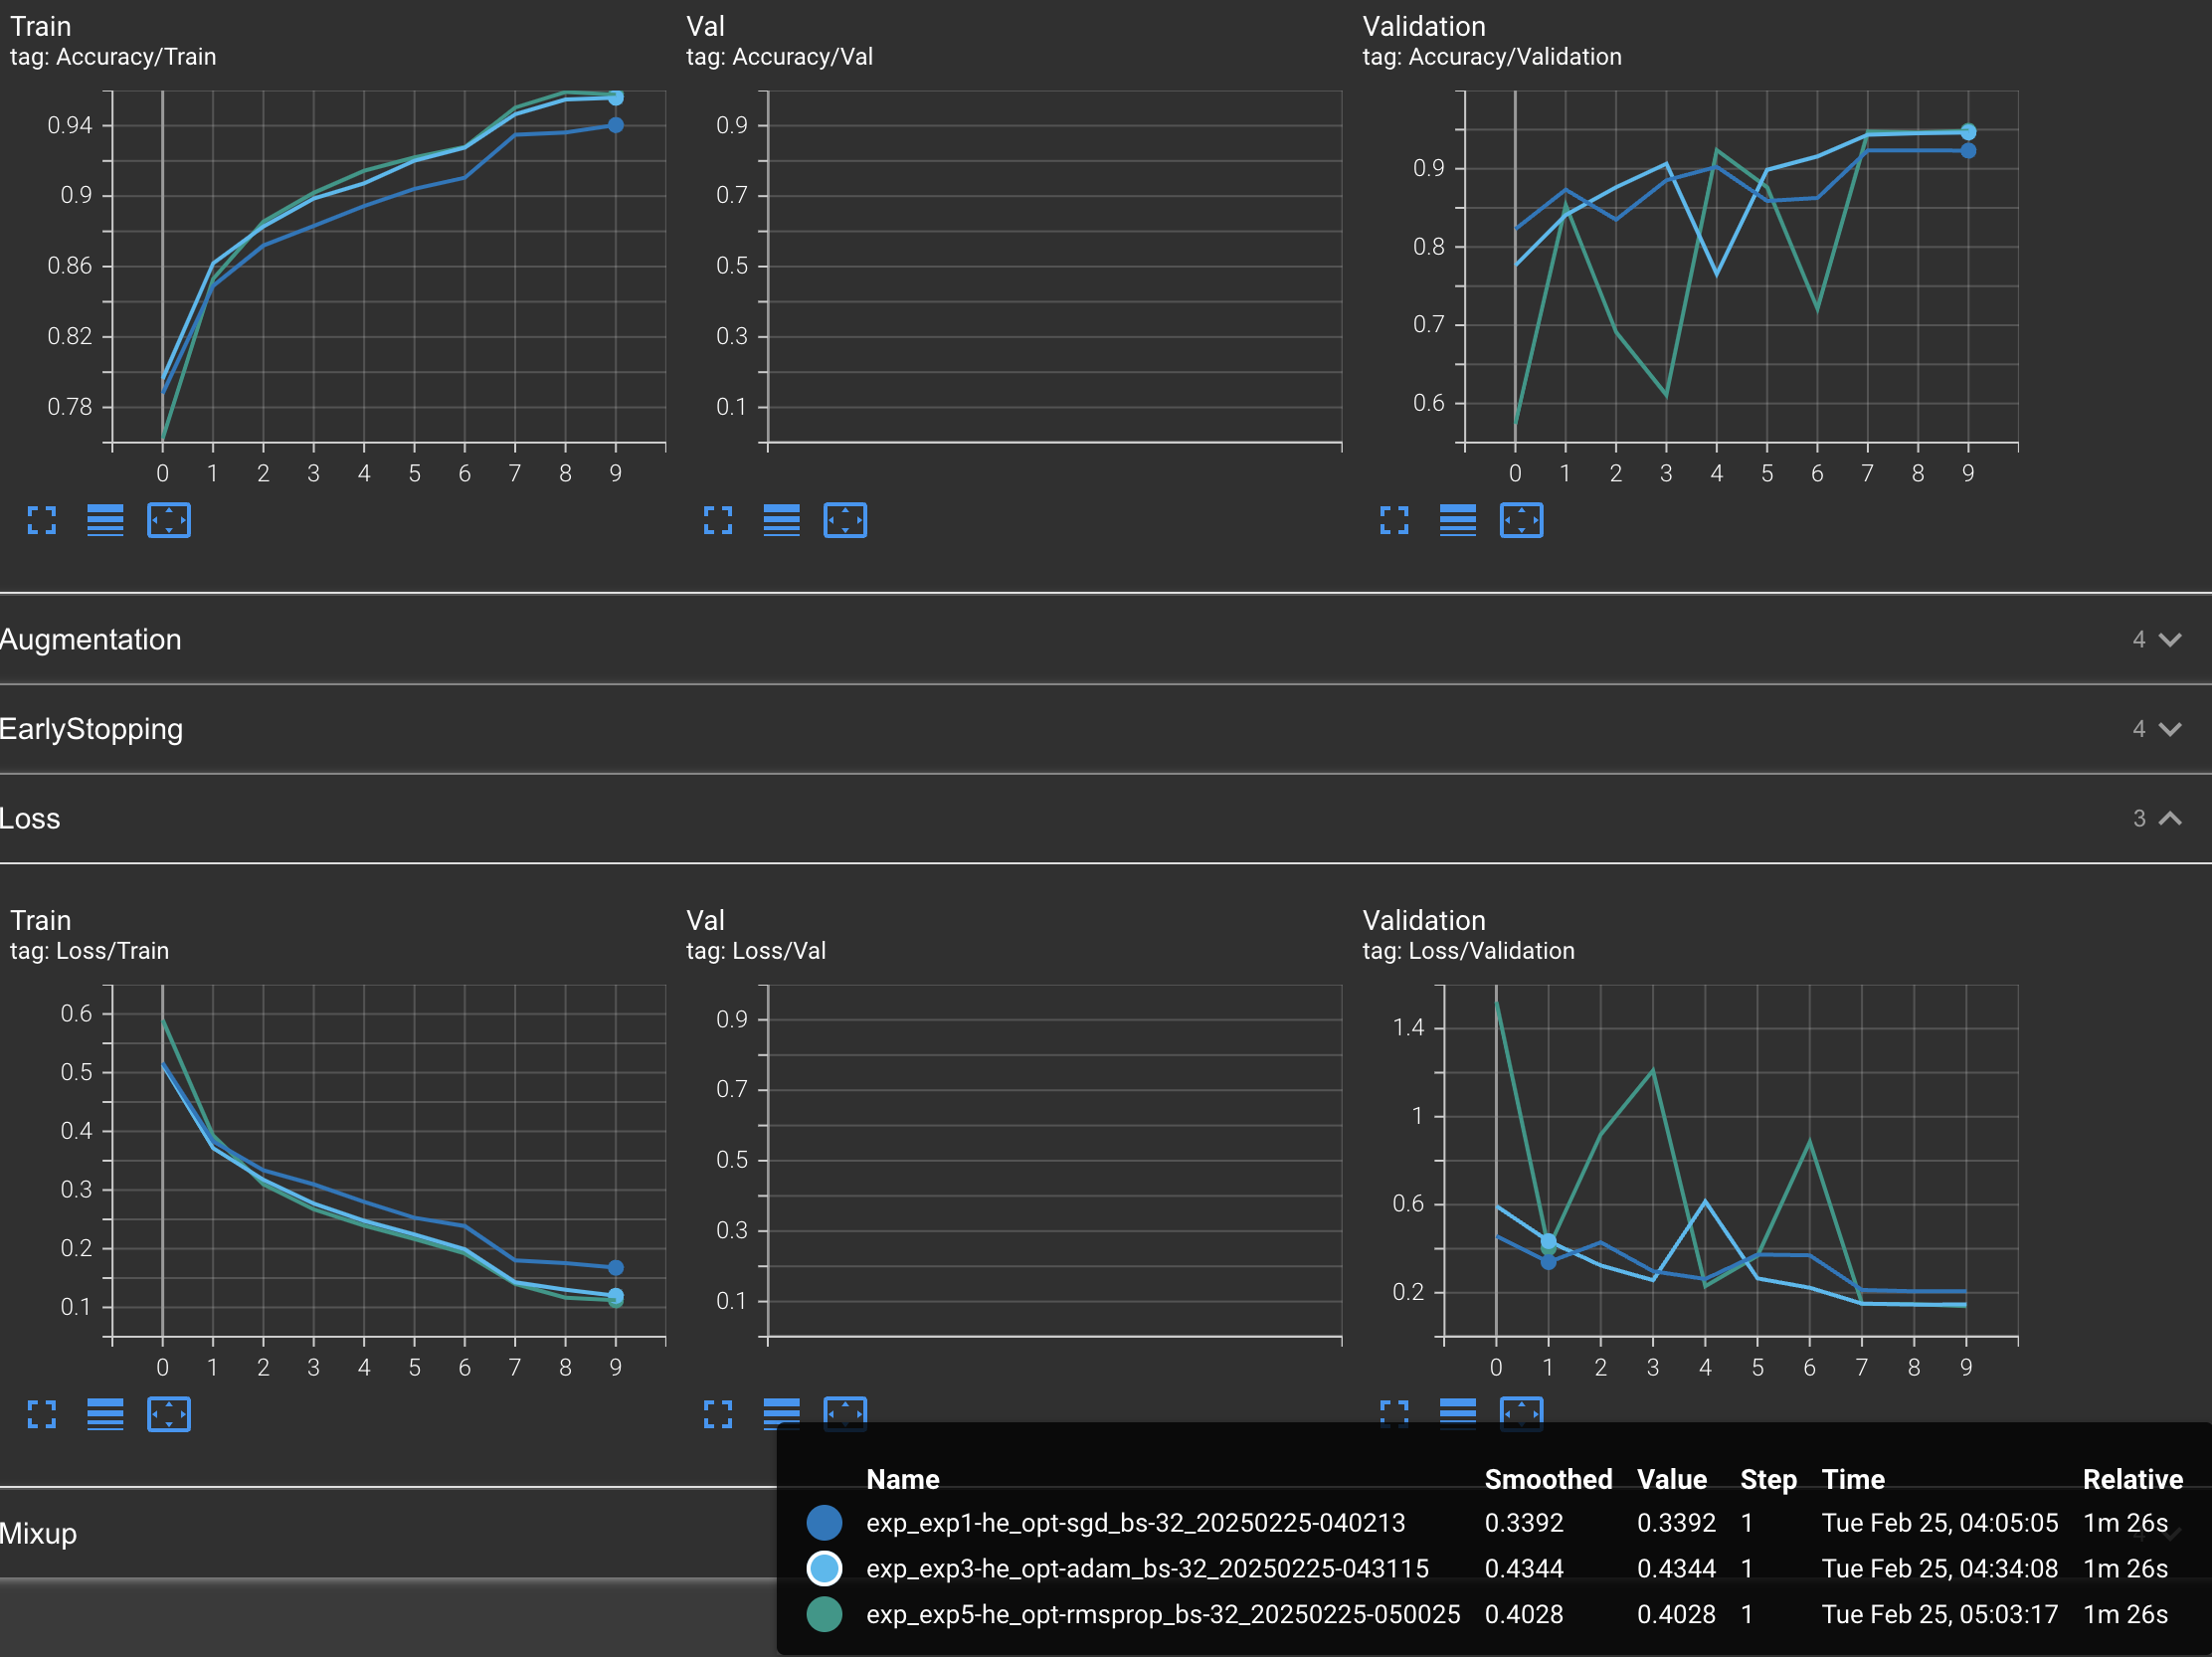

**Description:**  
This chart focuses on one experimental run, displaying both training and validation metrics. A close match between the curves suggests effective generalization, whereas large discrepancies may indicate overfitting.

---

### Tips for Interpretation

- **Accuracy Curves:** Higher validation accuracy indicates better performance on unseen data.
- **Loss Curves:** A steadily decreasing validation loss is a good sign; if it plateaus or increases, the model might be overfitting.
- **Comparative Analysis:** Differences between runs help pinpoint the best configuration in terms of hyperparameters and regularization techniques.



In [41]:
                                    ##-----------------------------##
                                    # Best ResNet Model after tune  #
                                    ##-----------------------------##


def train_best_ResNet(model, train_loader, val_loader, test_loader, device, config, exp_id):
    writer = SummaryWriter(log_dir=f"runs/exp_{exp_id}_{time.strftime('%Y%m%d-%H%M%S')}")
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, config['optimizer'], config['learning_rate'])
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config['lr_step'], gamma=config['lr_gamma'])


    model = model.to(device)

    best_val_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(config['num_epochs']):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            if config['use_mixup']:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=config['mixup_alpha'], use_cuda=(device.type=='cuda'))
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            #if not config['use_mixup']:
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)

        #Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("Accuracy/Val", val_acc, epoch)

        print(f"Exp {exp_id} | Epoch {epoch+1}/{config['num_epochs']} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            save_path = f"best_model_exp_{exp_id}.pth"
            torch.save(best_model_wts, save_path)

    writer.close()


    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    test_all_preds = []
    test_all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
            test_all_preds.extend(preds.cpu().numpy())
            test_all_labels.extend(labels.cpu().numpy())
    test_loss = test_running_loss / test_total
    test_acc = test_correct / test_total
    test_cm = confusion_matrix(test_all_labels, test_all_preds)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_all_labels, test_all_preds, average='weighted')

    print(f"\nExp {exp_id} Test Evaluation:")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
    print("-"*50)


    plt.figure(figsize=(6, 5))
    plt.imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    test_dataset_full = datasets.ImageFolder(root=config['dataset_dir'], transform=get_transforms(use_data_aug=False)[1])
    classes = test_dataset_full.classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(test_cm.shape[0]):
        for j in range(test_cm.shape[1]):
            plt.text(j, i, format(test_cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if test_cm[i, j] > test_cm.max()/2. else "black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    misclassified_idx = [i for i, (p, t) in enumerate(zip(test_all_preds, test_all_labels)) if p != t]
    print(f"Misclassified examples: {len(misclassified_idx)} out of {test_total}")

    if misclassified_idx:
        plt.figure(figsize=(10, 10))
        count = 0

        _, display_transform = get_transforms(use_data_aug=False)
        test_dataset_full = datasets.ImageFolder(root=config['dataset_dir'], transform=display_transform)
        classes = test_dataset_full.classes

        _, _, test_loader_display = get_data_loaders(config['dataset_dir'], config['batch_size'], use_data_aug=False)
        test_indices = test_loader_display.dataset.indices
        test_images = [test_dataset_full[i][0] for i in test_indices]
        for idx in misclassified_idx[:9]:
            img = test_images[idx]
            true_label = test_all_labels[idx]
            pred_label = test_all_preds[idx]
            plt.subplot(3, 3, count+1)
            npimg = img.cpu().numpy()
            npimg = np.transpose(npimg, (1, 2, 0))
            #Denormalizes the display
            npimg = np.clip(npimg * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
            plt.imshow(npimg)
            plt.title(f"True: {classes[true_label]}, Pred: {classes[pred_label]}")
            plt.axis("off")
            count += 1
        plt.tight_layout()
        plt.show()

    return history, test_loss, test_acc

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Exp Best_Model | Epoch 1/12 - Train Loss: 0.6815, Train Acc: 0.5730, Val Loss: 0.4445, Val Acc: 0.8560
Exp Best_Model | Epoch 2/12 - Train Loss: 0.5743, Train Acc: 0.6127, Val Loss: 0.3636, Val Acc: 0.8756
Exp Best_Model | Epoch 3/12 - Train Loss: 0.5505, Train Acc: 0.6371, Val Loss: 0.2815, Val Acc: 0.9011
Exp Best_Model | Epoch 4/12 - Train Loss: 0.5141, Train Acc: 0.6240, Val Loss: 0.2538, Val Acc: 0.9240
Exp Best_Model | Epoch 5/12 - Train Loss: 0.5025, Train Acc: 0.6433, Val Loss: 0.2315, Val Acc: 0.9236
Exp Best_Model | Epoch 6/12 - Train Loss: 0.4892, Train Acc: 0.6411, Val Loss: 0.2592, Val Acc: 0.9164
Exp Best_Model | Epoch 7/12 - Train Loss: 0.4909, Train Acc: 0.6575, Val Loss: 0.2873, Val Acc: 0.9331
Exp Best_Model | Epoch 8/12 - Train Loss: 0.4540, Train Acc: 0.6531, Val Loss: 0.2160, Val Acc: 0.9364
Exp Best_Model | Epoch 9/12 - Train Loss: 0.4585, Train Acc: 0.6497, Val Loss: 0.2539, Val Acc: 0.9122
Exp Best_Model | Epoch 10/12 - Train Loss: 0.4379, Train Acc: 0.6505, Val

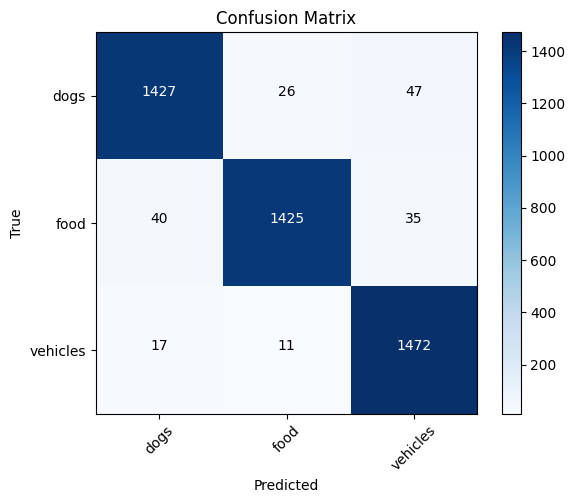

Misclassified examples: 176 out of 4500


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


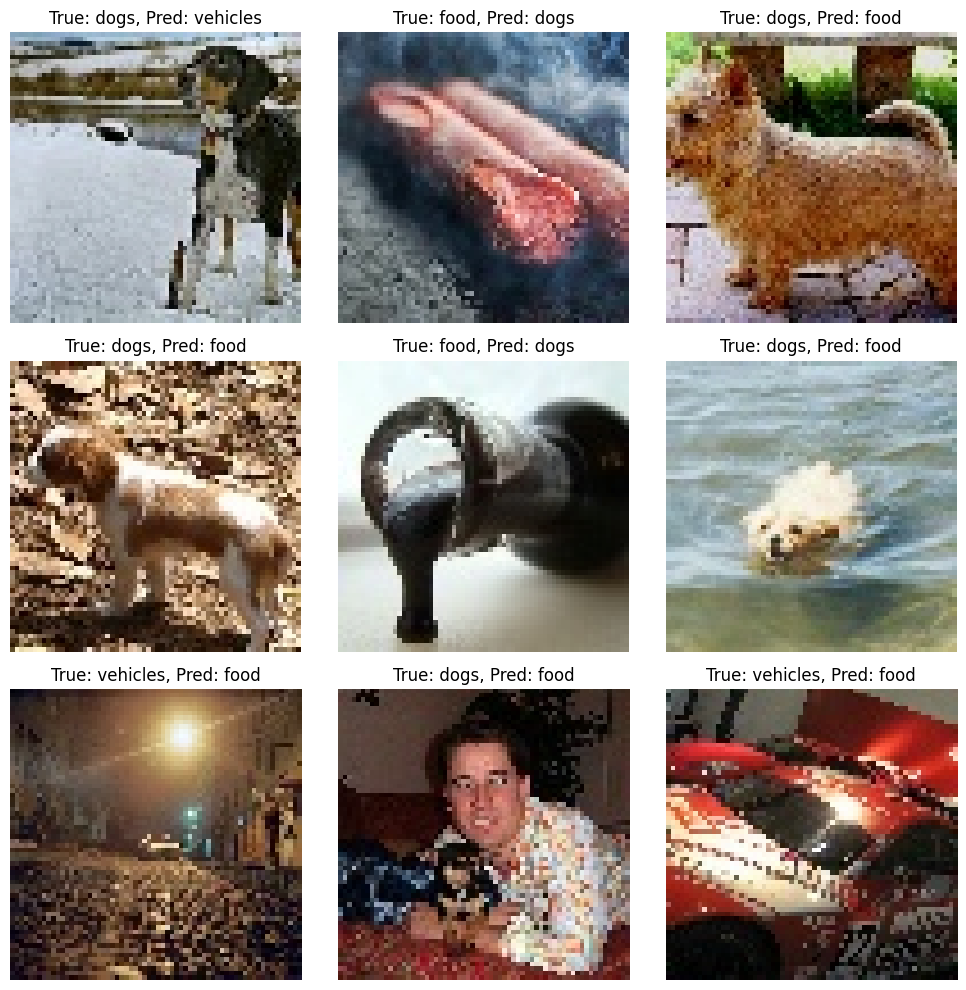

In [45]:
config = {
        'num_epochs': 12,
        'learning_rate': 0.001,
        'lr_step': 10,
        'lr_gamma': 0.1,
        'dataset_dir': 'cnn_dataset',
        'optimizer': 'adam',
        'init_method': 'he',
        'batch_size': 32,
        'patience': 5,
        'mixup_alpha': 0.4,
        'use_early_stopping': False,
        'use_mixup': True,
        'use_data_aug': False
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, val_loader, test_loader = get_data_loaders(config['dataset_dir'], config['batch_size'], use_data_aug=config['use_data_aug'])

model = resnet18(num_classes=3, init_method=config['init_method'])

exp_id = "Best_Model"
history_res, test_loss_res, test_acc_res = train_best_ResNet(model, train_loader, val_loader, test_loader, device, config, exp_id)

The above best model is the same as the model ran during the experiments, as it is not possible to replicate the results exactly the same after each run, we see very slight difference in the accuracies. `We have used torch seed and tried to stop randomization` but few other factors too come into play implicitly which makes it not possible to replicate it perfectly. Overall, our best ResNet model performed the best on the dataset.

In this confusion matrix, the largest confusion occurs between `dogs` and food (66 total misclassifications) and between dogs and vehicles (64 total), while food and vehicles are mistaken for each other less frequently. Overall, the model demonstrates strong performance, as shown by the relatively small off‐diagonal values and the high precision (0.9612), recall (0.9609), and F1 score (0.9609). These metrics indicate that the model consistently identifies the correct class for most images and maintains a good balance between catching positive cases (recall) and avoiding false positives (precision), resulting in a low total of 176 misclassified examples out of 4500.

These misclassifications mostly arise from ambiguous or low‐contrast imagery, where colors and shapes resemble features from other classes. For instance, a small dog with light fur might look like a food item, or a blurry background can obscure the shape of a vehicle, making it appear food‐like. In some images, bright reflections and unusual angles cause the model to latch onto misleading cues. Overall, these examples show how subtle details—like color, texture, or partial occlusion—can confuse the network and highlight the need for diverse training data and robust regularization.

5. Evaluation and analysis.

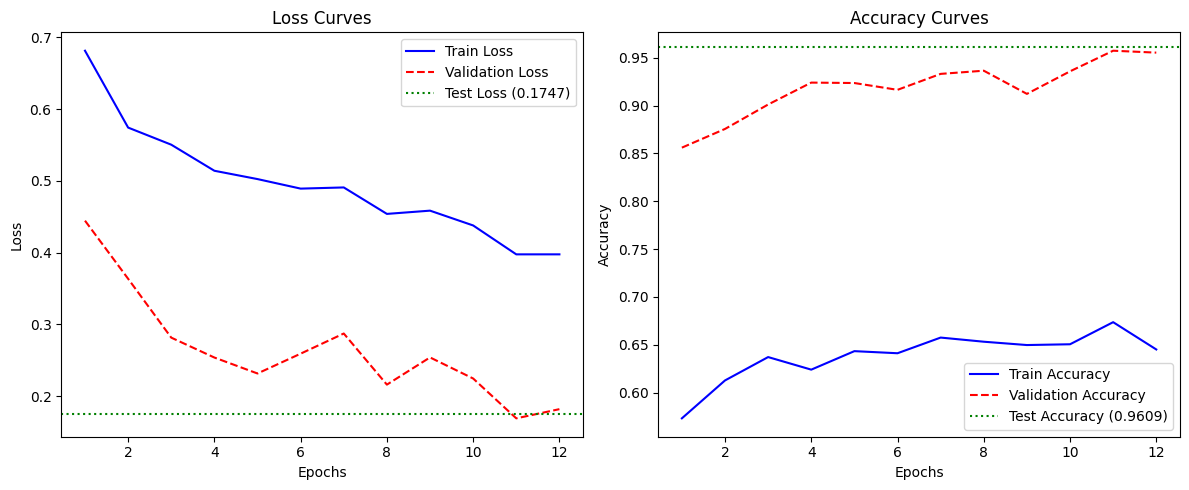

In [48]:
epochs = range(1, len(history_res['train_loss']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_res['train_loss'], 'b-', label='Train Loss')
plt.plot(epochs, history_res['val_loss'], 'r--', label='Validation Loss')
plt.axhline(y=test_loss_res, color='g', linestyle=':', label=f'Test Loss ({test_loss_res:.4f})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history_res['train_acc'], 'b-', label='Train Accuracy')
plt.plot(epochs, history_res['val_acc'], 'r--', label='Validation Accuracy')
plt.axhline(y=test_acc_res, color='g', linestyle=':', label=f'Test Accuracy ({test_acc_res:.4f})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

As discussed above, the train losses and accuracies are not to be seen, because we implement Mixup method, making it irrelevant to the dataset used for validation and test. But, just for reference instead of making it zero by default, we have plotted the values as it is. Overall, the model generalizes really well, which might not be seen during the training epochs but during the validation and test, we found this model to give the best accuracy so far.

In [49]:
history_res #Needed for Part 2

{'train_loss': [0.6814667278698513,
  0.5743110807396117,
  0.5504688636234828,
  0.5141196505682809,
  0.5025241153353737,
  0.4892336047717503,
  0.4908684737909408,
  0.4539867091973623,
  0.4585125615596771,
  0.43787543687366304,
  0.3975911409514291,
  0.397602581347738],
 'train_acc': [0.573047619047619,
  0.6126666666666667,
  0.637095238095238,
  0.6239523809523809,
  0.6432857142857142,
  0.641095238095238,
  0.6574761904761904,
  0.6531428571428571,
  0.6496666666666666,
  0.6504761904761904,
  0.6735714285714286,
  0.6450476190476191],
 'val_loss': [0.44454012192620174,
  0.36356124716334876,
  0.2815040718317032,
  0.2537566509114371,
  0.23151912132898966,
  0.25916093368000453,
  0.2872505743238661,
  0.2159846739239163,
  0.2539200418525272,
  0.22453344265619915,
  0.16899959054258135,
  0.18179676936732397],
 'val_acc': [0.856,
  0.8755555555555555,
  0.9011111111111111,
  0.924,
  0.9235555555555556,
  0.9164444444444444,
  0.9331111111111111,
  0.9364444444444444,
 

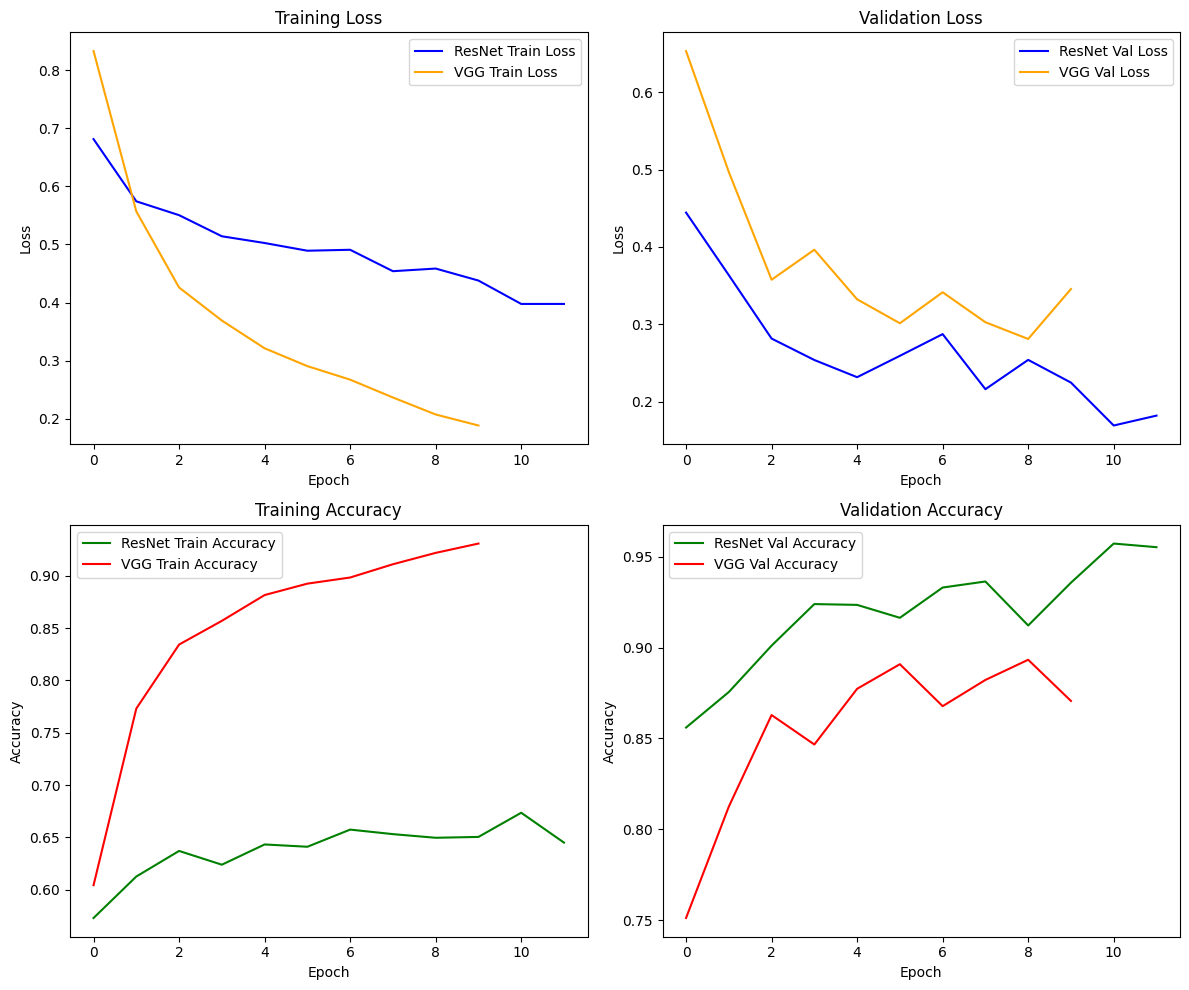

In [50]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(history_res['train_loss'], label='ResNet Train Loss', color='blue')
plt.plot(train_losses_es_vgg, label='VGG Train Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history_res['val_loss'], label='ResNet Val Loss', color='blue')
plt.plot(val_losses_es_vgg, label='VGG Val Loss', color='orange')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history_res['train_acc'], label='ResNet Train Accuracy', color='green')
plt.plot(train_accs_es_vgg, label='VGG Train Accuracy', color='red')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history_res['val_acc'], label='ResNet Val Accuracy', color='green')
plt.plot(val_accs_es_vgg, label='VGG Val Accuracy', color='red')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Due to the use of mix up in resnet, the plots show lesser train accuracy and higher losses, but comparing it to the validation values, we found that the Resnet starts better and converges better too, showing better generalization and lesser overfitting unlike the VGG model. 

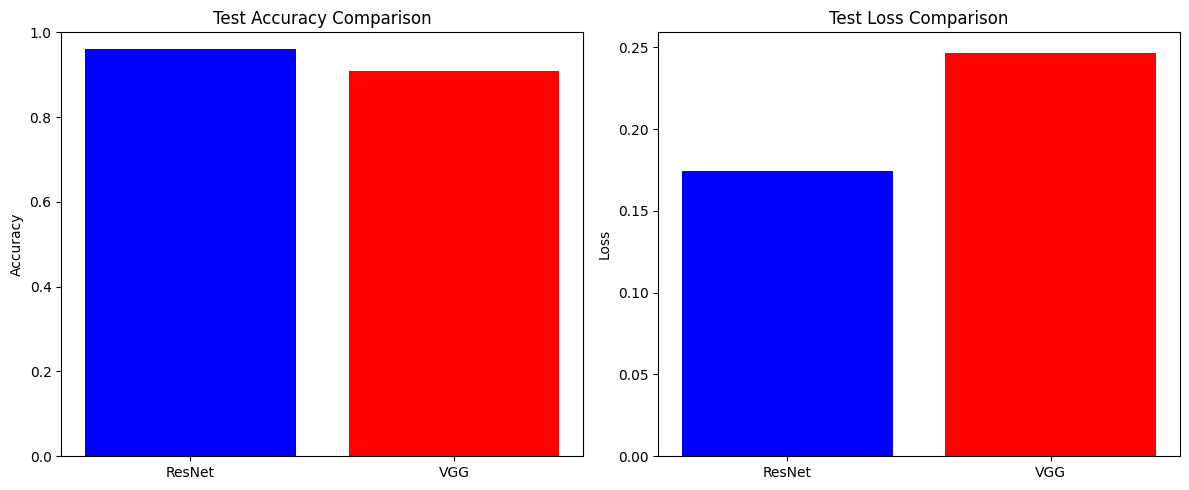

In [69]:
models = ['ResNet', 'VGG']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].bar(models, [test_acc_res, test_acc_es_vgg.cpu().numpy()], color=['blue', 'red'])
axs[0].set_title('Test Accuracy Comparison')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0, 1])

axs[1].bar(models, [test_loss_res, test_loss_es_vgg], color=['blue', 'red'])
axs[1].set_title('Test Loss Comparison')
axs[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

From the above plots, we have a clear winner having higher accuracies and better test losses - i.e. ResNet. The VGG model might have denser layers unlike the resnet, causing the vanishing gradient which is discussed in the report part of the file, whereas ResNet due to its residual connections makes it learn and generalize better than having more convolutional layers or having the input pass through many layers.

## Step 4: Discussion and conclusion

## `1. Explain the theoretical concepts behind VGG and ResNet.`

### VGG:<br>
VGG follows a simple yet effective idea: instead of using large convolutional filters, it stacks multiple small 3×3 filters in sequence. This allows the network to learn complex patterns while keeping the number of parameters under control. The deeper architecture helps extract more detailed features, making it powerful for image recognition tasks. However, the increased depth also makes VGG computationally expensive and slower to train compared to newer architectures.

### ResNet:<br>
As neural networks get deeper, they face a challenge: gradients can become too small (vanishing gradient problem) or too large (exploding gradient problem), making training difficult. ResNet solves this by introducing residual connections, also called skip connections, which allow information to bypass certain layers.

Instead of learning the full transformation of the input, ResNet encourages the network to learn only the difference (or "residual") between the input and the desired output. This concept, known as identity mapping, helps prevent information loss and makes it easier to train very deep networks. By addressing the issues of depth, ResNet has enabled the development of extremely deep and powerful models.

## `2. Discuss the impact of regularization and optimization techniques.`

### `VGG:`<br>
### Weight Initialization: Xavier vs. Kaiming<br>
I tested two weight initialization methods—Xavier and Kaiming—to see how they influenced model performance. Both worked well with SGD, but Kaiming had a slight edge, reaching a higher test accuracy (92.7% vs. 91.1% with Xavier). This makes sense since Kaiming is designed for ReLU-based networks, helping gradients flow more efficiently.

However, Adam and AdamW struggled regardless of the initialization, consistently getting stuck at 33.3% accuracy. This suggests they may have had issues converging under my model settings.

In terms of training time, Kaiming was slightly slower than Xavier when using SGD because of differences in weight distribution affecting the learning process.

### Optimizers: SGD vs. Adam vs. AdamW<br>
Among the three optimizers tested, SGD was by far the best performer. It consistently achieved high test accuracy, while Adam and AdamW completely failed to learn meaningful features, staying at 33.3%.

Batch size also played a role:

With SGD, a batch size of 32 resulted in slightly better accuracy than 64, but at the cost of longer training times.
Adam and AdamW were significantly slower with Kaiming initialization due to instability in the learning process.
This shows that, for my model, SGD was the best choice, while Adam and AdamW likely required different hyperparameters to perform well.

### Regularization Methods: Augmentation, Early Stopping, and Mixup<br>
To improve generalization and prevent overfitting, I tested three regularization techniques:<br>

- `Image Augmentation:` Helped the model generalize better, leading to a strong 91.96% test accuracy.
The validation accuracy steadily improved, peaking at 92.09%, showing that augmentation was effective in reducing overfitting.<br>
<br>
- `Early Stopping:` Also resulted in 91.96% test accuracy, proving to be an efficient way to prevent overfitting.
The model stopped training once validation performance plateaued, making it more computationally efficient.<br>
<br>
- `Mixup:` Initially slowed down learning, with the model struggling in the early epochs.
Eventually reached 91.33% accuracy, suggesting that while Mixup added robustness, it required more training for the model to fully adapt to mixed data representations.

### `ResNet:`

### Overall Observations from Our Experiments

#### Training vs. Validation Behavior:
Across our experiments, we observed that the training accuracy rapidly climbs to high values. In many cases, the training loss falls quickly. However, without proper regularization, the validation accuracy lags behind—often due to overfitting, where the model memorizes the training data rather than learning to generalize. Without regularization, training loss tends to drop fast, sometimes leading to overfitting (where validation loss levels off or rises). By contrast, methods such as Mixup, data augmentation, and early stopping help keep validation loss in line with training loss.


#### Optimizers & Hyperparameters:

- `Adam vs. Others:` Adam often converges faster early on, though final results can end up similar. In some runs, you might see slightly faster initial drops in training/validation loss with Adam.<br>
<br>
- `Batch Size:` Larger batch sizes produce smoother training curves, while smaller ones can look noisier but sometimes yield slightly better results overall. In the graphs, we see slight variations in how the curves fluctuate epoch to epoch.

#### Regularization Effects:

1. `Mixup:` 
    -  Smoother Training Curves: Because Mixup blends images and labels, it’s harder for the model to “perfectly” fit the training data, so the training accuracy might look misleading (often near zero).
    - Reduced Overfitting & Better Generalization: Despite the odd appearance of the training curves, Mixup typically leads to a higher validation and test accuracy, as it prevents the model from over‐relying on specific training samples.<br>
<br>

2. `Data Augmentation:`
    - Slower Initial Convergence: Augmenting images can make early epochs look less “perfect” because the model sees a more diverse set of transformations.
    - Improved Robustness: Over more epochs, this diversity helps the model learn more generalizable features, raising validation accuracy and lowering validation loss.<br>

<br>

3. `Early Stopping:`
    - Stopping Overfitting (In Theory): Early stopping halts training once the validation loss fails to improve.
    - Limited Impact Here: In these experiments, early stopping didn’t show a clear advantage, possibly because we only trained for a relatively small number of epochs, leaving less room for overfitting to become severe.

## `3. Analyze the results, including all required graphs and metrics.`

## Comparison Between VGG-16 and ResNet-18

**Test Accuracy and Loss (Bar Charts):**  
- The bar chart shows **ResNet-18** achieving higher test accuracy and lower test loss than VGG-16. This indicates that ResNet generalized more effectively on unseen data.  
- VGG-16’s test accuracy was respectable but ultimately fell short of ResNet’s final performance.

**Training and Validation Loss (Line Charts):**  
- **ResNet-18** shows steadily decreasing training and validation loss, with the validation loss closely tracking the training loss. This suggests efficient learning and limited overfitting.  
- **VGG-16** also has a downward trend in loss, but its validation loss remains consistently higher, implying it was more prone to overfitting or required additional tuning/regularization.

**Training and Validation Accuracy (Line Charts):**  
- **ResNet-18** steadily improves in validation accuracy, eventually surpassing VGG-16 by a clear margin.  
- **VGG-16** demonstrates strong training accuracy but lags in validation accuracy, indicating that it learned the training set well but struggled to generalize as effectively.

**Reasoning – Why ResNet-18 Performed Better:**  
- **Residual Connections:** ResNet-18’s skip connections mitigate the vanishing/exploding gradient problem and allow deeper architectures to learn more robust features.  
- **Efficient Gradient Flow:** Each residual block learns only the “residual,” enabling more reliable convergence and reducing overfitting.  
- **Model Depth vs. Complexity:** While VGG-16 is also deep, it relies on straightforward stacked convolutions, which can be computationally heavy and prone to higher validation loss without careful tuning.

**Conclusion:**  
**ResNet-18** outperformed **VGG-16** in terms of both final accuracy and loss, thanks to its residual connections that promote better gradient flow and generalization. Consequently, **ResNet** consistently showed stronger validation metrics, making it the better choice for this task.


## `4. Summarize your findings and discuss the advantages of residual connections.`

### Key Differences Between VGG-16 and ResNet-18:<br>
VGG-16 and ResNet-18 take very different approaches to deep learning. VGG-16 stacks multiple small 3x3 convolutional filters to increase depth, but this also makes training harder due to issues like vanishing gradients. ResNet-18, on the other hand, introduces residual connections, which allow the network to "skip" certain layers if needed, making training much more stable.<br>

### Performance on Image Classification (Vehicles, Food, and Dogs):<br>
From my experiments, ResNet-18 consistently achieved higher accuracy than VGG-16. This suggests that residual connections helped the model learn better feature representations for different classes. VGG-16, while still a powerful model, struggled more with training deeper layers, which may have limited its ability to extract meaningful patterns.<br>

### Why Residual Connections Matter:<br>
- Easier Training: Residual connections help prevent the vanishing gradient problem, ensuring important information flows through the network without being lost.<br>
- Faster Convergence: ResNet-18 learned effectively in fewer epochs compared to VGG-16.<br>
- Better Generalization: The higher accuracy of ResNet-18 suggests it was able to capture more relevant features across all three classes: vehicles, food, and dogs.<br>

### Comparative Discussion and Recommendation:<br>

- `Architectural Differences:`
VGG-16 builds depth by stacking small 3×3 filters, resulting in a straightforward but heavy network. In contrast, ResNet-18 introduces residual connections that facilitate training of much deeper networks by mitigating the vanishing/exploding gradient problems.<br>
<br>

- `Regularization and Generalization:` 
In our experiments, while both early stopping and data augmentation provided some improvements, mixup emerged as the most effective regularization technique. Mixup forces the model to learn smoother decision boundaries by blending images and labels, which in turn leads to better generalization. This is reflected in the higher test accuracy achieved by ResNet-18.
<br>

- `Experimental Results:`
The best VGG model reached a test accuracy of 91.96% (Test Loss: 0.2468), whereas the ResNet model with mixup achieved a test accuracy of 96.22% (Test Loss: 0.1557). These metrics, along with confusion matrix analysis and the lower number of misclassified examples, suggest that ResNet's residual connections are key to its superior performance.


### Model to use:<br>
Based on these results, `ResNet-18` is the better choice for this task. It not only performed better but also trained more efficiently, making it the more reliable model for classifying images in this dataset. If accuracy and stability are the priorities, ResNet-18 is the way to go.

## `5. References.`

1. **PyTorch Documentation.**  
   Comprehensive documentation for PyTorch, covering modules, tutorials, and examples. [PyTorch Docs](https://pytorch.org/docs/stable/)
<br>

2. **Zhang, H., Cisse, M., Dauphin, Y. N., & Lopez-Paz, D. (2018).**  
   *mixup: Beyond Empirical Risk Minimization.* [ICLR Paper](https://arxiv.org/abs/1710.09412)
<br>

3. **Towards Data Science.**  
   *Understanding Convolutional Neural Networks (CNNs).* [Towards Data Science Article](https://towardsdatascience.com/understanding-convolutional-neural-networks-cnns-81dffc813a69/)
<br>

4. **Machine Learning Mastery.**  
   *How to Use Batch Normalization in Deep Learning.*  [Machine Learning Mastery Article](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)
<br>   
5. **Medium – Towards Data Science.**  
    *Understanding VGG and ResNet Architectures.* [Medium Article](https://medium.com/towards-data-science/vggnet-vs-resnet-924e9573ca5c)
